# Exploration Data Analysis on Vehicle Recalls

**Author:** Harris Zheng

**Date:** February 27th, 2025

## Imports

In [4]:
import pandas as pd
import pprint
import numpy as np
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import string
import re


In [5]:
PARENT_DIR = os.getcwd().rsplit("\\", maxsplit=1)[0]
DATASET_DIR = os.path.join(PARENT_DIR, "Datasets")

In [6]:
df = pd.read_csv(f"{DATASET_DIR}/FLAT_RCL.txt", sep='\t', header=None, on_bad_lines='skip')
# use the column names listed above
df.columns = ['RECORD_ID', 'CAMPNO', 'MAKETXT', 'MODELTXT', 'YEARTXT', 'MFGCAMPNO', 'COMPNAME', 'MFGNAME', 'BGMAN', 'ENDMAN', 'RCLTYPECD', 'POTAFF', 'ODATE', 'INFLUENCED_BY', 'MFGTXT', 'RCDATE', 'DATEA', 'RPNO', 'FMVSS', 'DESC_DEFECT', 'CONSEQUENCE_DEFECT', 'CORRECTIVE_ACTION', 'NOTES', 'RCL_CMPT_ID', 'MFR_COMP_NAME', 'MFR_COMP_DESC', 'MFR_COMP_PTNO']
df.head()

C:\Users\harri\AppData\Local\Temp\ipykernel_104164\90671655.py:1: DtypeWarning: Columns (17,18,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{DATASET_DIR}/FLAT_RCL.txt", sep='\t', header=None, on_bad_lines='skip')


RECORD_ID     CAMPNO          MAKETXT        MODELTXT  YEARTXT MFGCAMPNO  \
0          1  02V288000             FORD           FOCUS     2000     02S41   
1          2  02V288000             FORD           FOCUS     2001     02S41   
2          3  02V236000            JAYCO  FT EAGLE 10 SG     2003       NaN   
3          4  02V237000  HOLIDAY RAMBLER        ENDEAVOR     2000       NaN   
4          5  02V237000  HOLIDAY RAMBLER        ENDEAVOR     1999       NaN   

                                       COMPNAME             MFGNAME  \
0  ELECTRICAL SYSTEM:12V/24V/48V BATTERY:CABLES  FORD MOTOR COMPANY   
1  ELECTRICAL SYSTEM:12V/24V/48V BATTERY:CABLES  FORD MOTOR COMPANY   
2                        EQUIPMENT:OTHER:LABELS         JAYCO, INC.   
3                                     STRUCTURE  MONACO COACH CORP.   
4                                     STRUCTURE  MONACO COACH CORP.   

        BGMAN      ENDMAN  ... RPNO  FMVSS  \
0  19990719.0  20010531.0  ...  NaN    NaN   
1  19990719.0  20010531.0  ...  NaN    NaN   
2  20020730.0  20020813.0  ...  NaN    NaN   
3         NaN         NaN  ...  NaN    NaN   
4         NaN         NaN  ...  NaN    NaN   

                                         DESC_DEFECT  \
0  CERTAIN PASSENGER VEHICLES EQUIPPED WITH ZETEC...   
1  CERTAIN PASSENGER VEHICLES EQUIPPED WITH ZETEC...   
2  ON CERTAIN FOLDING TENT CAMPERS, THE FEDERAL C...   
3  ON CERTAIN CLASS A MOTOR HOMES, THE FLOOR TRUS...   
4  ON CERTAIN CLASS A MOTOR HOMES, THE FLOOR TRUS...   

                                  CONSEQUENCE_DEFECT  \
0  THIS, IN TURN, COULD CAUSE THE BATTERY CABLES ...   
1  THIS, IN TURN, COULD CAUSE THE BATTERY CABLES ...   
2  IF THE TIRES WERE INFLATED TO 80 PSI, THEY COU...   
3  CONDITIONS CAN RESULT IN THE BOTTOMING OUT THE...   
4  CONDITIONS CAN RESULT IN THE BOTTOMING OUT THE...   

                                   CORRECTIVE_ACTION  \
0  DEALERS WILL INSPECT THE BATTERY CABLES FOR TH...   
1  DEALERS WILL INSPECT THE BATTERY CABLES FOR TH...   
2  OWNERS WILL BE MAILED CORRECT LABELS FOR INSTA...   
3  DEALERS WILL INSPECT THE FLOOR TRUSS NETWORK S...   
4  DEALERS WILL INSPECT THE FLOOR TRUSS NETWORK S...   

                                               NOTES  \
0  ALSO CONTACT THE NATIONAL HIGHWAY TRAFFIC SAFE...   
1  ALSO CONTACT THE NATIONAL HIGHWAY TRAFFIC SAFE...   
2  ALSO, CUSTOMERS CAN CONTACT THE NATIONAL HIGHW...   
3  CUSTOMERS CAN ALSO CONTACT THE NATIONAL HIGHWA...   
4  CUSTOMERS CAN ALSO CONTACT THE NATIONAL HIGHWA...   

                   RCL_CMPT_ID MFR_COMP_NAME MFR_COMP_DESC MFR_COMP_PTNO  
0  000015339000215021000000202           NaN           NaN           NaN  
1  000015339000215022000000202           NaN           NaN           NaN  
2  000015210000106403000000349           NaN           NaN           NaN  
3  000015211000083965000000272           NaN           NaN           NaN  
4  000015211000080938000000272           NaN           NaN           NaN  

[5 rows x 27 columns]

## Utilities

In [15]:
def find_columns_defining_uniqueness(df : pd.DataFrame, duplicates_allowed=0,
                                     uniqueness_column="CAMPNO"):
    '''
        Find columns that defines a dataframe's uniqueness
        based on duplicate threshold requirements.

        TODO Need to return score indicating how much uniqueness each column added
        (ex. uniqueness can be measured by how much less duplicates there are due to column added)

        df : DataFrame
        duplicates_allowed : how many ODINOs we want in our final dataset
        uniqueness_column : the column that you think should give unique rows but doesn't
    '''
    prev_length = -1
    columns_defining_uniqueness = [uniqueness_column]
    while len(df) > 0 and len(df[uniqueness_column].unique()) > duplicates_allowed:
        # Find column with max unique counts that's not already selected
        unique_counts_per_campno = df.groupby(uniqueness_column).nunique().sum(axis=0).sort_values(ascending=False)
        print(unique_counts_per_campno)
        max_unique_count = -1
        max_unique_count_index = -1
        for i, column in enumerate(unique_counts_per_campno.index):
            if column in columns_defining_uniqueness:
                continue
            else:
                max_unique_count = unique_counts_per_campno.loc[column]
                max_unique_count_index = i
                break
        
        if max_unique_count == -1:
            break

        if max_unique_count > len(df[uniqueness_column].unique()):
            columns_defining_uniqueness.append(unique_counts_per_campno.index[max_unique_count_index])
            df = df.loc[df.duplicated(subset=columns_defining_uniqueness, keep=False)]
        else:
            # No more column additions brings value
            break
    return columns_defining_uniqueness



In [16]:
def get_random_row(df : pd.DataFrame):
    rand_row = df.sample().iloc[0]
    print("RECORD_ID:", rand_row["RECORD_ID"])
    pprint.pprint(f"COMPNAME: {rand_row['COMPNAME']}")
    pprint.pprint(f"DESC_DEFECT: {rand_row['DESC_DEFECT']}")
    pprint.pprint(f"CONSEQUENCE_DEFECT: {rand_row['CONSEQUENCE_DEFECT']}")
    pprint.pprint(f"CORRECTIVE_ACTION: {rand_row['CORRECTIVE_ACTION']}")
    pprint.pprint(f"NOTES: {rand_row['NOTES']}")

In [17]:
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.alpha"] = "0.2"
plt.rcParams["grid.linestyle"] = "-."

## Preprocessing

In [7]:
# Lowercase all strings for analysis
for column in df.columns:
    if df[column].dtype == object:
        df[column] = df[column].str.lower()
        df[column] = df[column].fillna("")

df["MMYTXT"] = (
    df["MAKETXT"] + " " + df["MODELTXT"] + " " + df["YEARTXT"].astype(str)
)

df["CDESCR"] = df["DESC_DEFECT"].str.cat(
    df[["CONSEQUENCE_DEFECT", "CORRECTIVE_ACTION"]],
    sep="\n\n"
)

## Descriptive Summary

In [8]:
len(df)

293171

In [9]:
df.dtypes

RECORD_ID               int64
CAMPNO                 object
MAKETXT                object
MODELTXT               object
YEARTXT                 int64
MFGCAMPNO              object
COMPNAME               object
MFGNAME                object
BGMAN                 float64
ENDMAN                float64
RCLTYPECD              object
POTAFF                float64
ODATE                 float64
INFLUENCED_BY          object
MFGTXT                 object
RCDATE                  int64
DATEA                   int64
RPNO                   object
FMVSS                  object
DESC_DEFECT            object
CONSEQUENCE_DEFECT     object
CORRECTIVE_ACTION      object
NOTES                  object
RCL_CMPT_ID            object
MFR_COMP_NAME          object
MFR_COMP_DESC          object
MFR_COMP_PTNO          object
MMYTXT                 object
CDESCR                 object
dtype: object

**Interesting Columns:**
POTAFF = Potential Affected Units
DESC_DEFECT = Description of Defect
CONSEQUENCE_DEFECT = Consequence of Defect
CORRECTIVE_ACTION = Corrective Action
NOTES = Notes

In [10]:
df.describe()

RECORD_ID        YEARTXT         BGMAN        ENDMAN        POTAFF  \
count  293171.000000  293171.000000  1.213470e+05  1.215890e+05  2.928850e+05   
mean   146587.072258    2828.429275  2.002491e+07  2.005949e+07  2.867357e+05   
std     84632.515632    2422.611396  1.423301e+05  1.492394e+05  7.466108e+05   
min         1.000000    1949.000000  2.090211e+06  2.040211e+06  0.000000e+00   
25%     73293.500000    2006.000000  1.997010e+07  1.999123e+07  7.420000e+02   
50%    146586.000000    2017.000000  2.005040e+07  2.008113e+07  1.219600e+04   
75%    219881.500000    2021.000000  2.011113e+07  2.015071e+07  2.427220e+05   
max    293174.000000    9999.000000  3.019051e+07  3.019043e+07  3.200000e+07   

              ODATE        RCDATE         DATEA  
count  2.804070e+05  2.931710e+05  2.931710e+05  
mean   2.013967e+07  2.013514e+07  2.013729e+07  
std    1.864228e+05  1.262811e+05  1.197836e+05  
min    1.111111e+07  1.966012e+07  1.979101e+07  
25%    2.009073e+07  2.008072e+07  2.008072e+07  
50%    2.020063e+07  2.019122e+07  2.019122e+07  
75%    2.022071e+07  2.022052e+07  2.022052e+07  
max    2.025022e+07  2.025022e+07  2.025022e+07

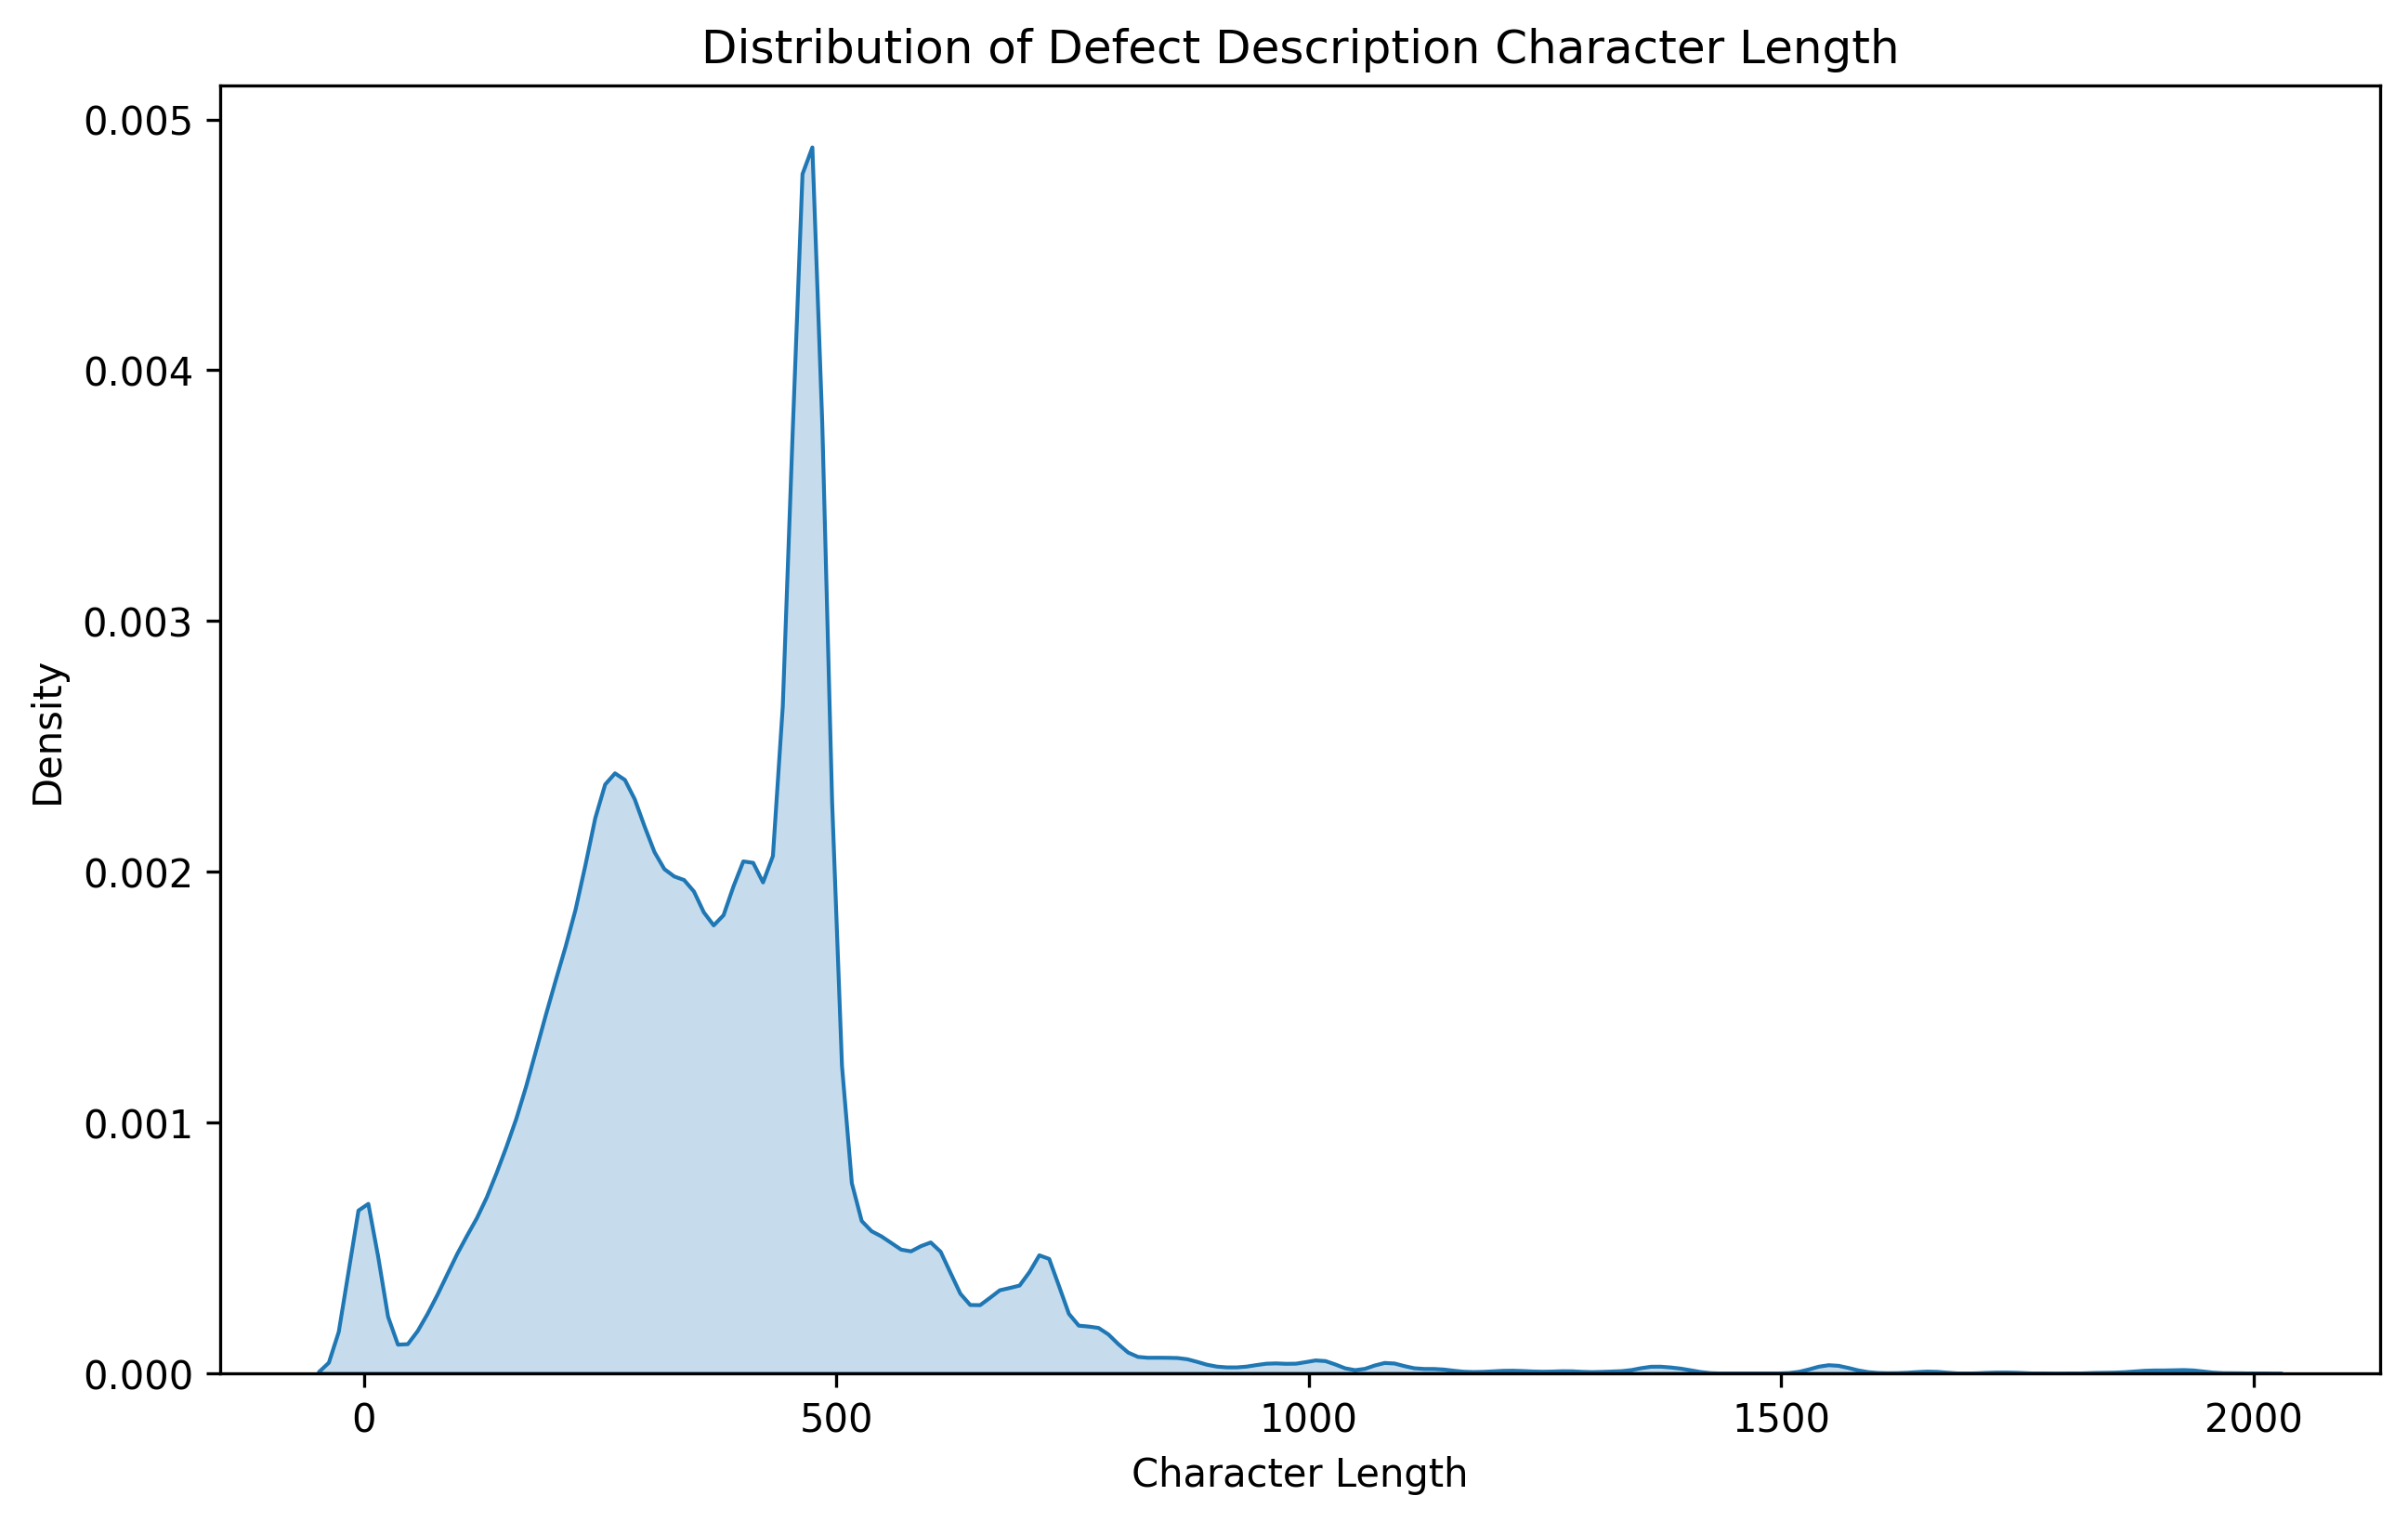

In [11]:
df_string_length = df["DESC_DEFECT"].str.len()
plt.figure(figsize=(10, 6), dpi=300)
sns.kdeplot(data=df_string_length, fill=True)
plt.title("Distribution of Defect Description Character Length")
plt.xlabel("Character Length")
plt.ylabel("Density")
plt.show()


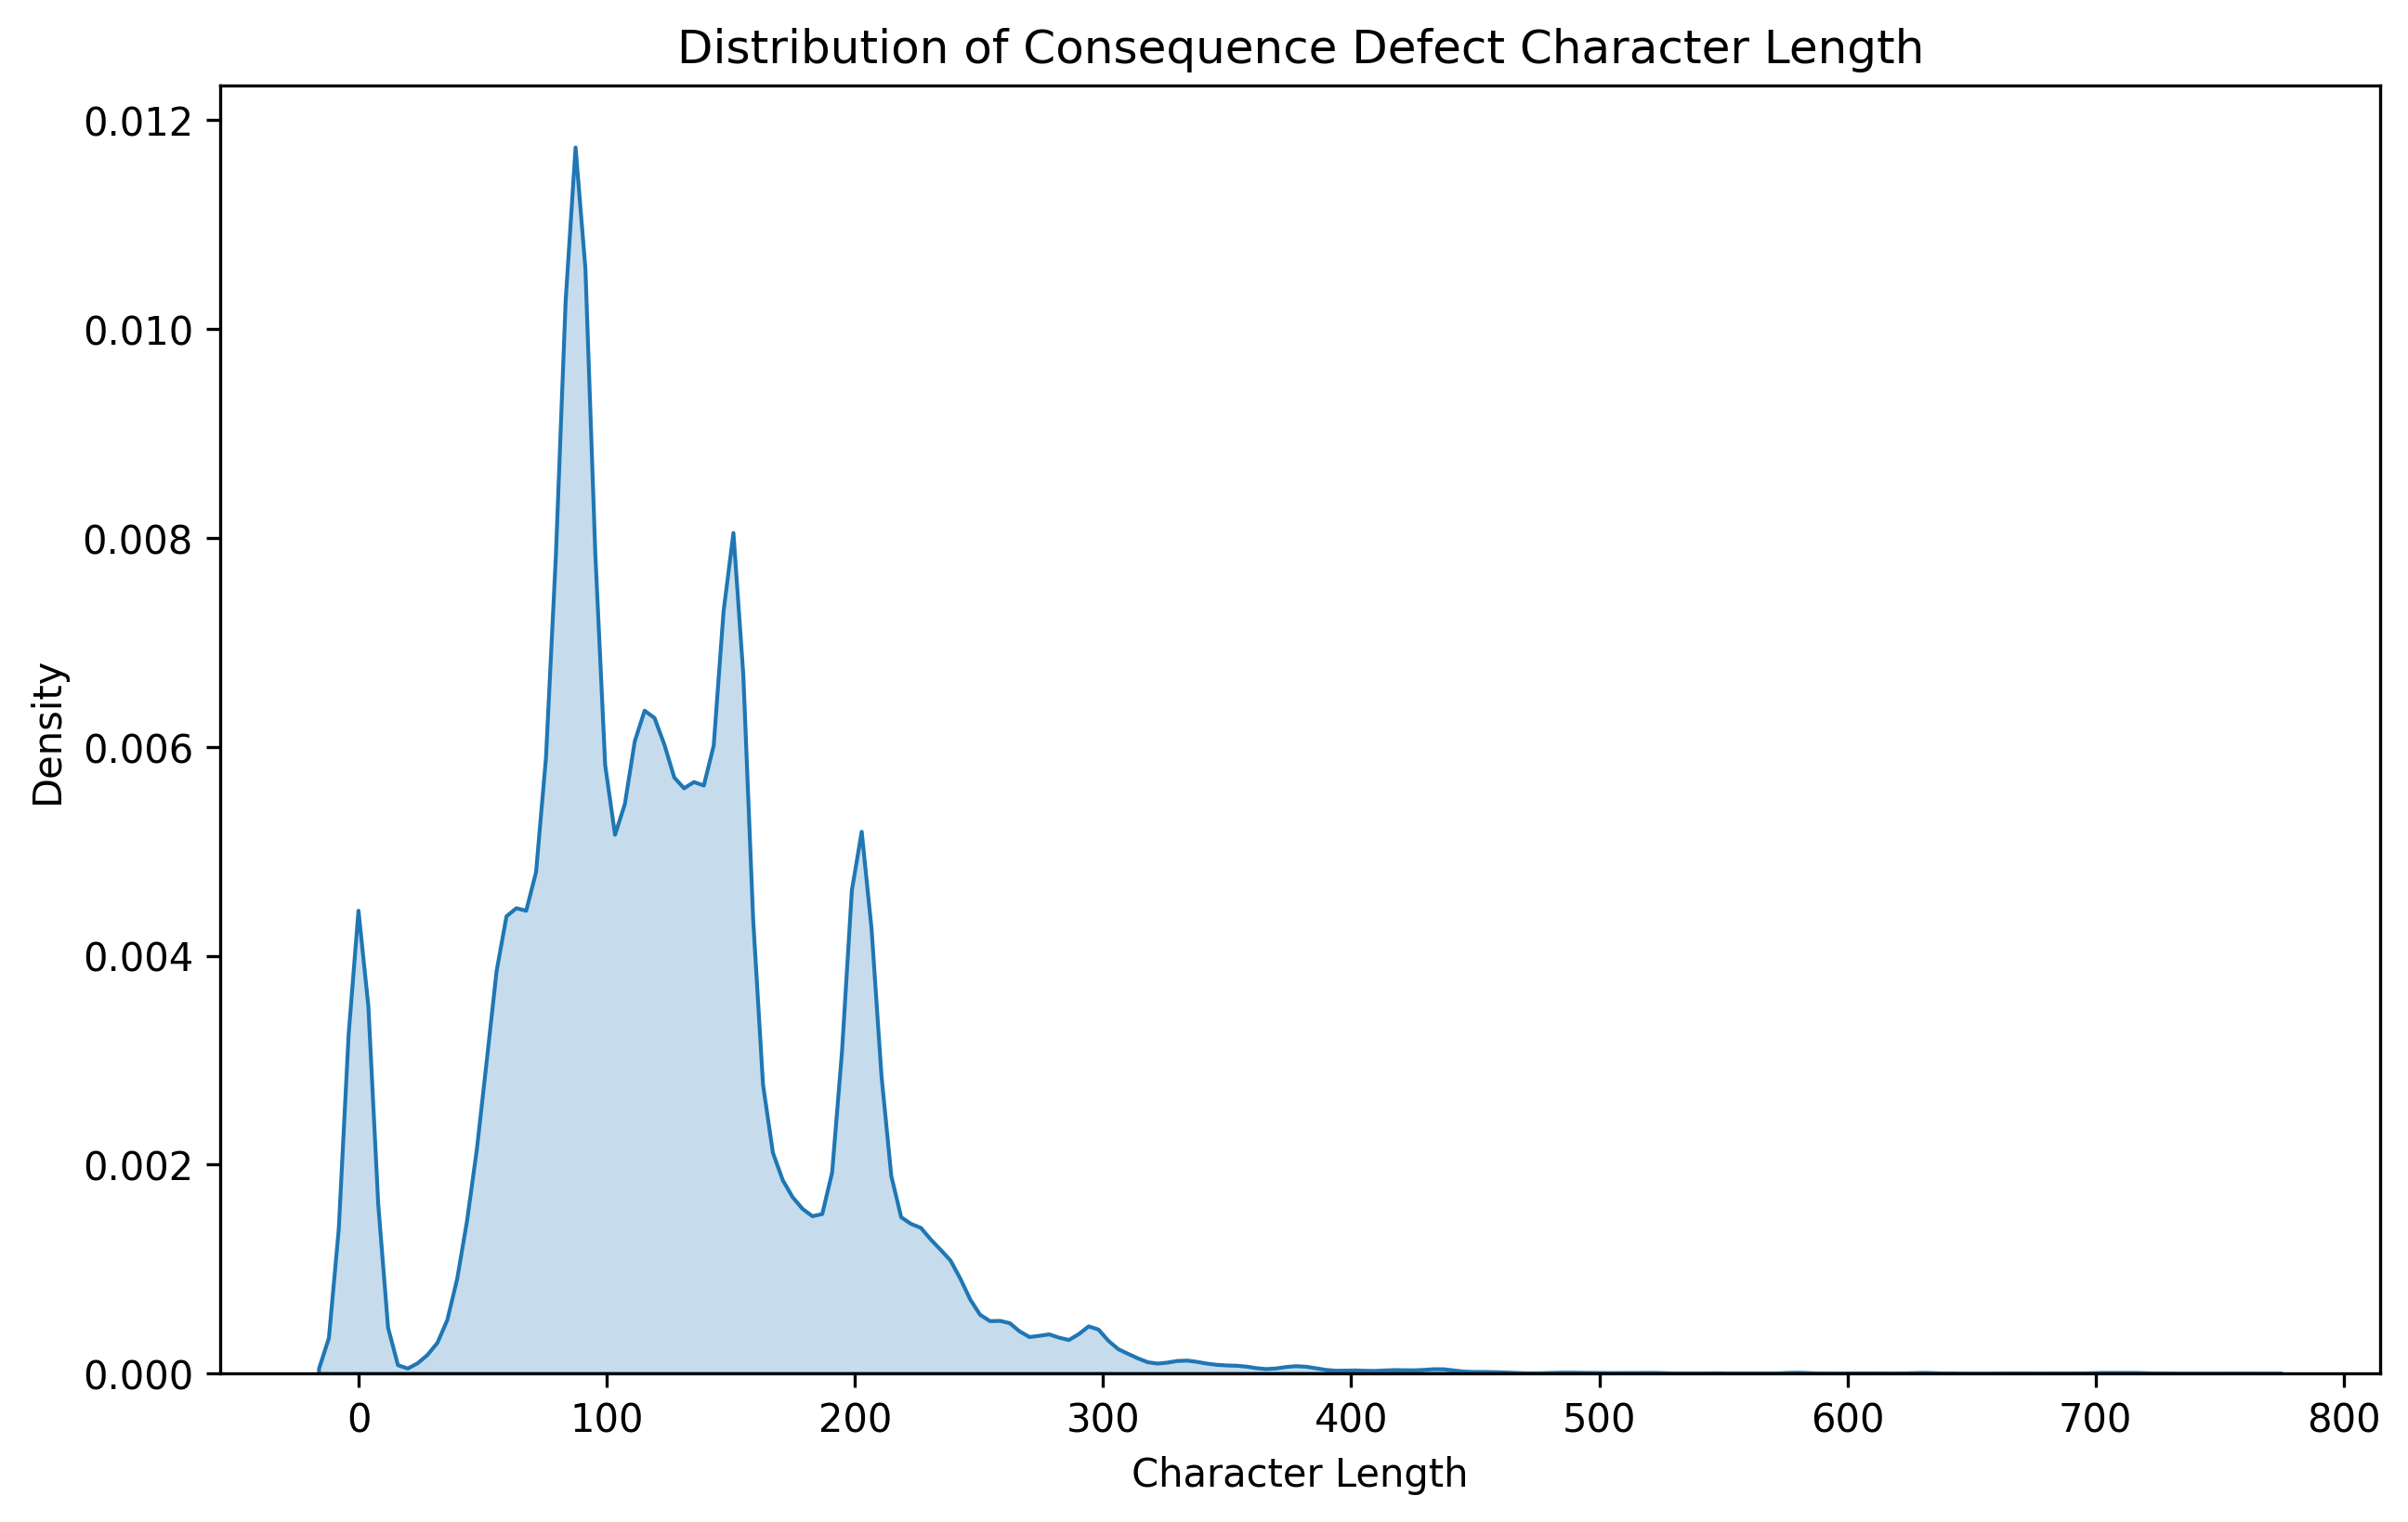

In [12]:
df_string_length = df["CONSEQUENCE_DEFECT"].str.len()
plt.figure(figsize=(10, 6), dpi=300)
sns.kdeplot(data=df_string_length, fill=True)
plt.title("Distribution of Consequence Defect Character Length")
plt.xlabel("Character Length")
plt.ylabel("Density")
plt.show()


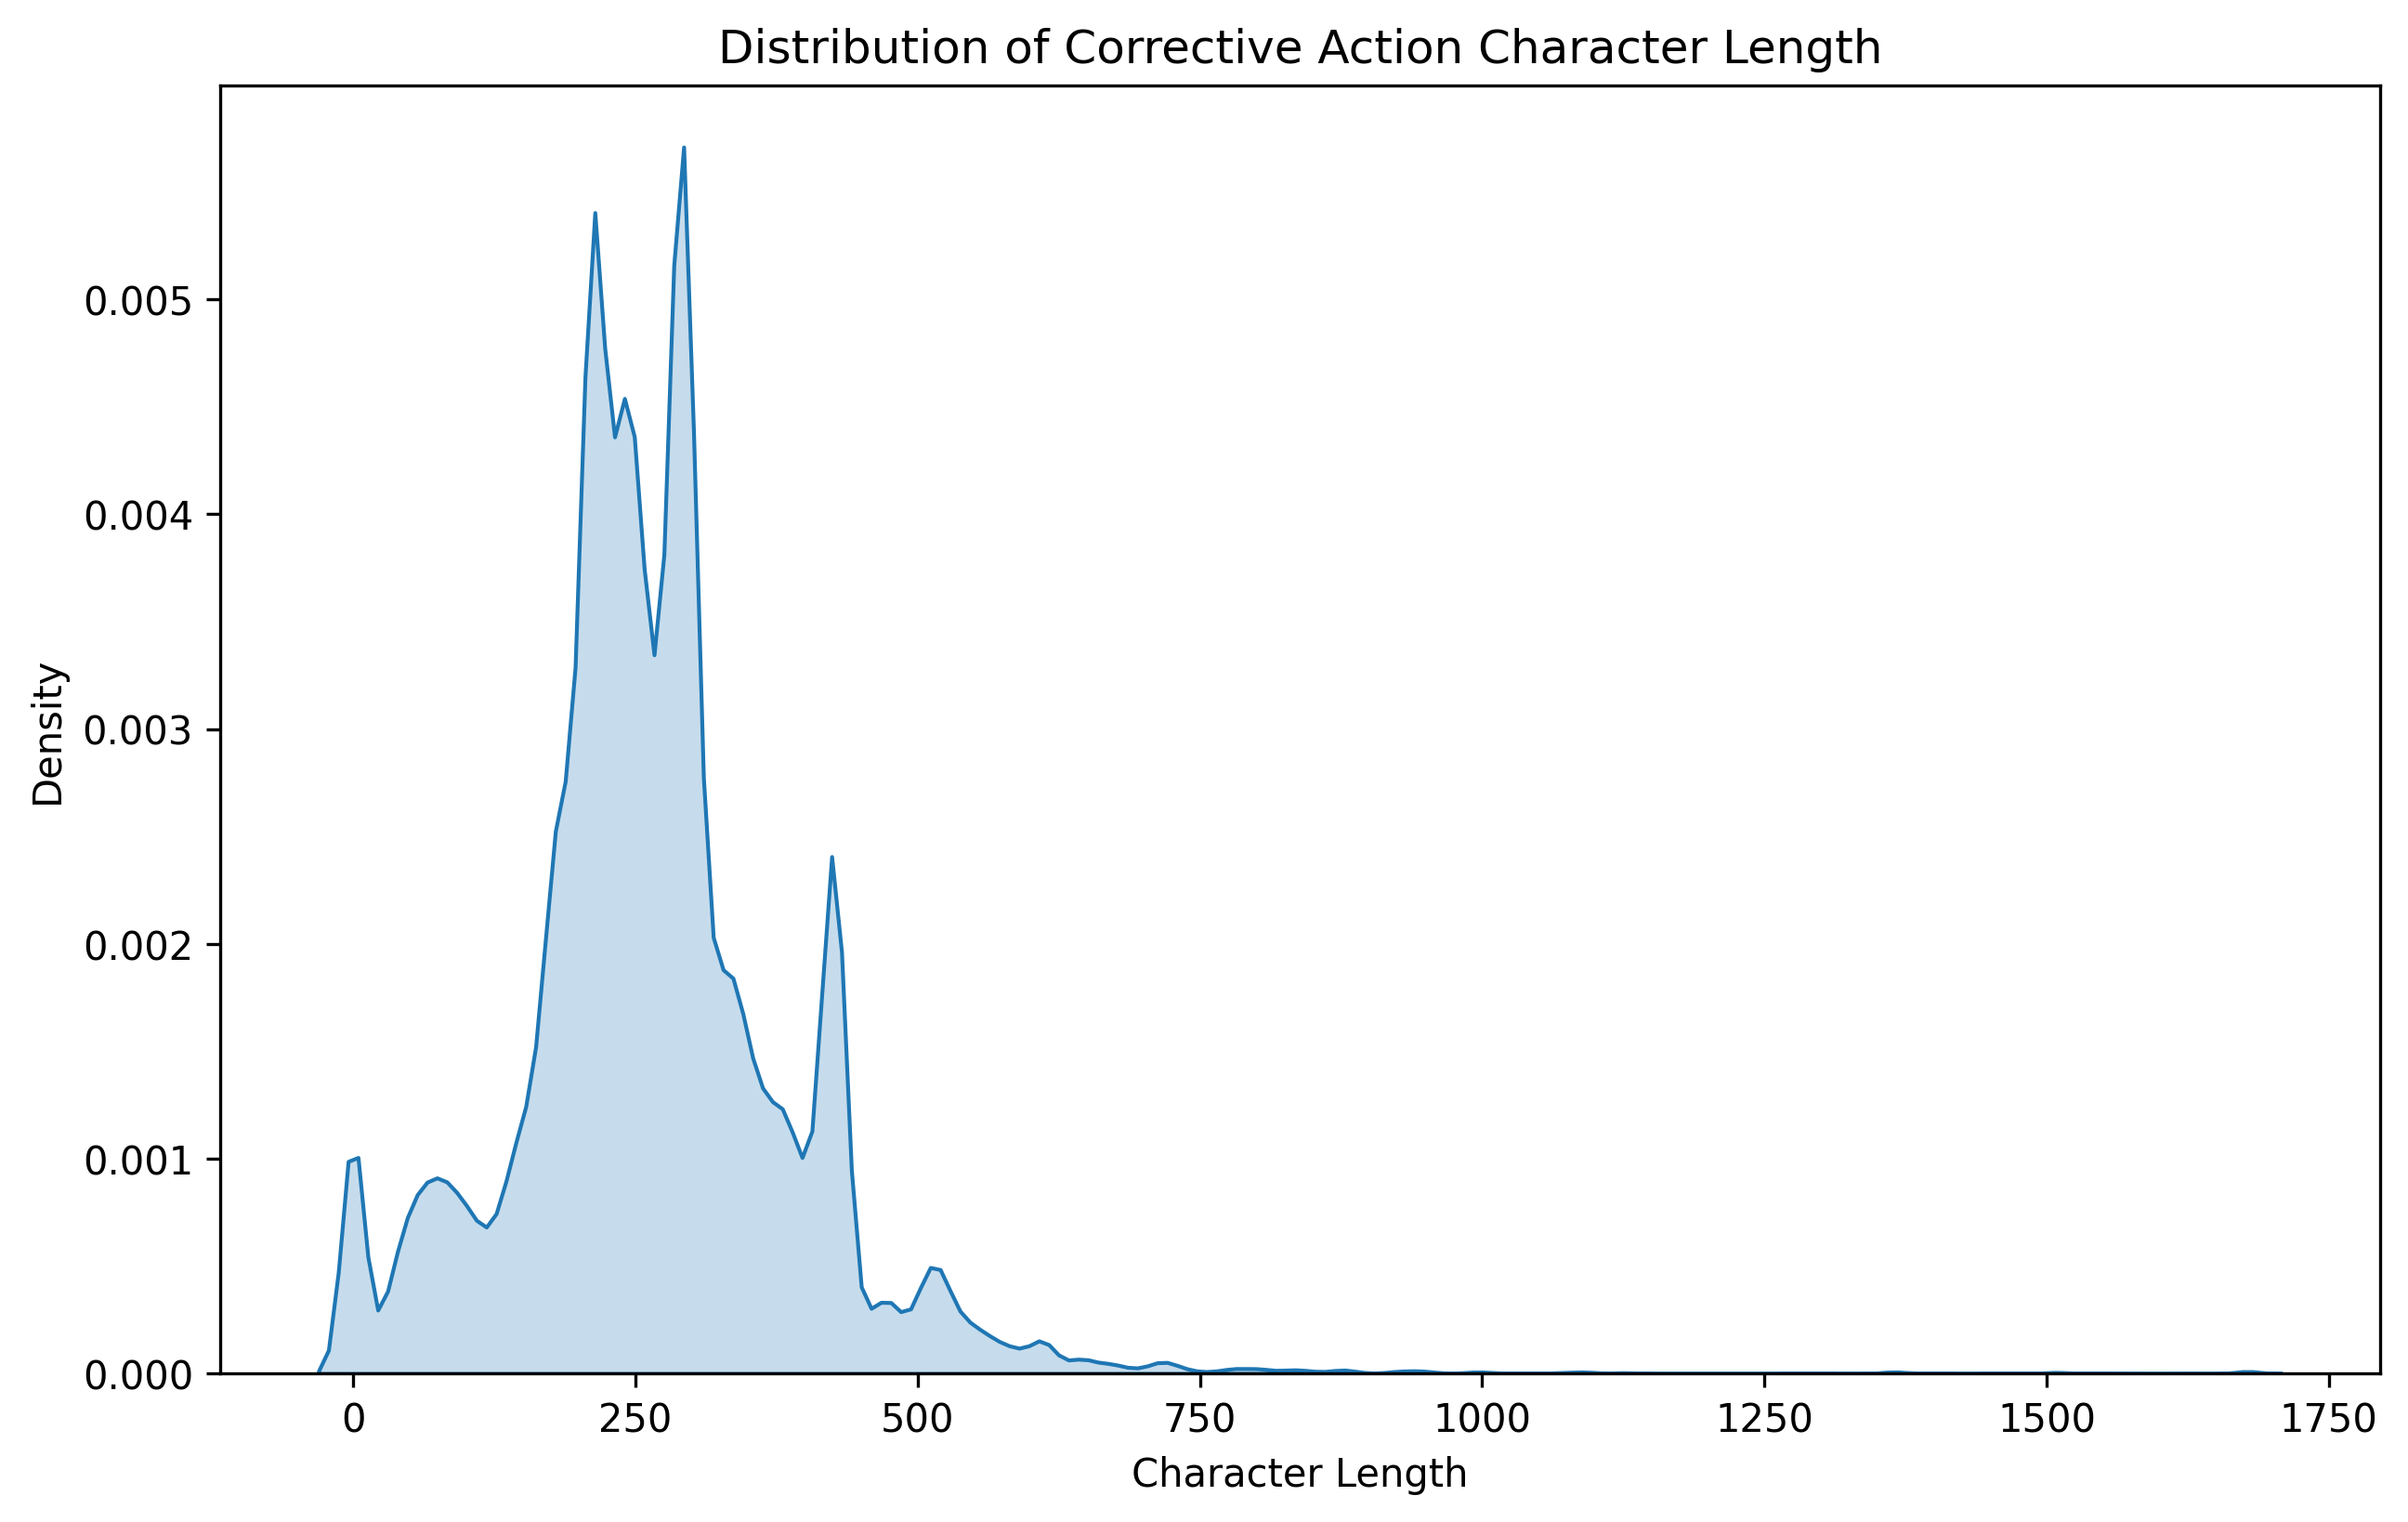

In [13]:
df_string_length = df["CORRECTIVE_ACTION"].str.len()
plt.figure(figsize=(10, 6), dpi=300)
sns.kdeplot(data=df_string_length, fill=True)
plt.title("Distribution of Corrective Action Character Length")
plt.xlabel("Character Length")
plt.ylabel("Density")
plt.show()


## Data Exploration

### Sampling

Sample some rows

In [34]:
ign = (df["DESC_DEFECT"].str.lower().str.contains("mbusa").fillna(False))
get_random_row(df.loc[ign])

RECORD_ID: 223931
'COMPNAME: electrical system:software'
('DESC_DEFECT: mercedes-benz usa, llc (mbusa) is recalling certain 2017-2022 '
 'cla-class, gla-class, gle-class, gls-class, slc-class, a-class, amg '
 'gt-class, c-class, e-class, s-class, sl-class, glc-class, cls-class, '
 "glb-class, and g-class vehicles.  please refer to mbusa's recall report for "
 "specific vehicle model details.  an error in the communication module's sim "
 'card software can cause a mobile network connection failure, disabling the '
 'emergency call (ecall) system.')
('CONSEQUENCE_DEFECT: a disabled ecall system would prevent a vehicle occupant '
 'from contacting the emergency services call center in an emergency, '
 'potentially delaying emergency responders and increasing the risk of injury.')
('CORRECTIVE_ACTION: the communication module software will be updated through '
 'an over-the-air (ota) update or by a dealer, free of charge.  owner '
 'notification letters were mailed july 8, 2022.  owner no

C:\Users\harri\AppData\Local\Temp\ipykernel_77852\2936250344.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ign = (df["DESC_DEFECT"].str.lower().str.contains("mbusa").fillna(False))


In [70]:
get_random_row(df)

RECORD_ID: 68009
'COMPNAME: exterior lighting:brake lights:switch'
('DESC_DEFECT: gm is recalling 185,903 model year 2004-2009 colorado, gmc '
 'model year 2009-2004 canyon, model year 2006 i-280, i-350, model year '
 '2007-2008 i-290, and i-370, passenger vehicles originally sold in or '
 'currently registered in the states of alabama, arizona, florida, georgia, '
 'hawaii, louisiana, mississippi, nevada, new mexico, puerto rico, south '
 'carolina, texas, u.s. virgin islands and utah.  some of these vehicles have '
 'a brake lamp switch that may not work as designed due to contamination in '
 'the switch.')
('CONSEQUENCE_DEFECT: this condition could cause the simultaneous loss of all '
 'brake lamps or cause all of the brake lamps to stay on continuously. both of '
 "these conditions could fail to warn others of the driver's intentions and "
 'could lead to a vehicle crash.')
('CORRECTIVE_ACTION: dealers will inspect and replace the necessary components '
 'as specified in the recall

### Null Hypothesis: Exact Match is Good Enough

LDA and Wordcloud will help me explore semantic relationships in the dataset columns: ["COMPNAME", "DESC EFFECT", "CONSEQUENCE_DEFECT", "CORRECTIVE_ACTION", "NOTES"]. If they don't exist, then we can rely on exact match for information retrieval.

### Wordcloud Plotting

In [36]:
from wordcloud import WordCloud
import spacy

In [37]:
# Not yet time for SpaCy Tokenization.
# SpaCy Tokenization is better than NLTK: 
# https://medium.com/towards-data-science/hands-on-implementation-of-basic-nlp-techniques-nltk-or-spacy-687099e02816
nlp = spacy.load('en_core_web_sm')

In [38]:
def plot_distrib(df: pd.DataFrame, column_name: str,
                bins=None):
    '''
      Plot distribution on histogram
      :param df: polars dataframe
      :param column_name: column name to plot distribution of
      :param bins: number of bins to use
    '''
    fig, ax = plt.subplots()
    if bins is None:
      ## Assume values ar from range 1 to num_unique if bins are not specified
      num_unique = len(df[column_name].unique())
      bins = [i+1 for i in range(num_unique+1)]

    _, _, patches = ax.hist(x=df[column_name], align='left',
                bins=bins,
                rwidth=0.8)
    _ = ax.set_title(f"Distribution of {column_name}")
    _ = ax.set_ylabel("Number of Reviews")
    _ = ax.set_xlabel(column_name)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.xaxis.set_major_locator(ticker.FixedLocator(bins[:-1]))
    totals = sum(ax.containers[0].datavalues)
    max_bar_height = max([patch.get_height() for patch in patches])
    slight_padding = max_bar_height * 0.01
    for i, patch in enumerate(patches):
      bar_height = patch.get_height()
      proportion_of_max_height = bar_height / max_bar_height
      if proportion_of_max_height < 0.05:
        # Place the label above the bar
        ax.text(patch.get_x() + patch.get_width() / 2, bar_height + slight_padding, f'{bar_height/totals*100:.2f}%',
                ha='center', va='bottom', color='black')
      else:
        # Place the label inside the bar
        ax.text(patch.get_x() + patch.get_width() / 2, bar_height - slight_padding, f'{bar_height/totals*100:.2f}%',
                ha='center', va='top', color='white')
    # ax.bar_label(ax.containers[0], color="white",
    #              padding=-15,
    #              labels=[f"{x/totals * 100:.2f}%"
    #                      if not np.isclose(x, 0) else ""
    #                      for x in ax.containers[0].datavalues])
    return fig, ax

def generate_word_frequencies_from_column(df, column):
    # Find all words in the column
    all_words = df[column].str.findall("\\b\\w\\w+\\b").explode(column)
    all_words = all_words.str.lower()

    # Get word counts. We have column in column string for word and column 'count' for frequency 
    word_frequencies = all_words.value_counts().reset_index()

    # Remove stopwords and words which do not contain letters (ex. 2016, 2017, 2018)
    uninterested_words_filter = (
        (word_frequencies[column].isin(nlp.Defaults.stop_words)) |
        ~(word_frequencies[column].str.contains("[a-zA-Z]"))
    )
    word_frequencies = word_frequencies.loc[
        ~uninterested_words_filter
    ]
    escaped_puncs = re.escape(string.punctuation)
    # There should be no punctuations present in any of the words
    assert len(
        word_frequencies[word_frequencies[column].str.contains('|'.join(escaped_puncs.split()))]
    ) == 0, \
    "There should be no punctuations in the analyzed words"
    return word_frequencies.set_index(column)


### COMPNAME Distribution

Name of component with defect

In [39]:
compname_word_freq = generate_word_frequencies_from_column(df, "COMPNAME")

In [40]:
compname_word_freq = compname_word_freq[~(compname_word_freq.index.isin(["system", "equipment"]))]

In [41]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=0.75, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(compname_word_freq.to_dict()["count"])

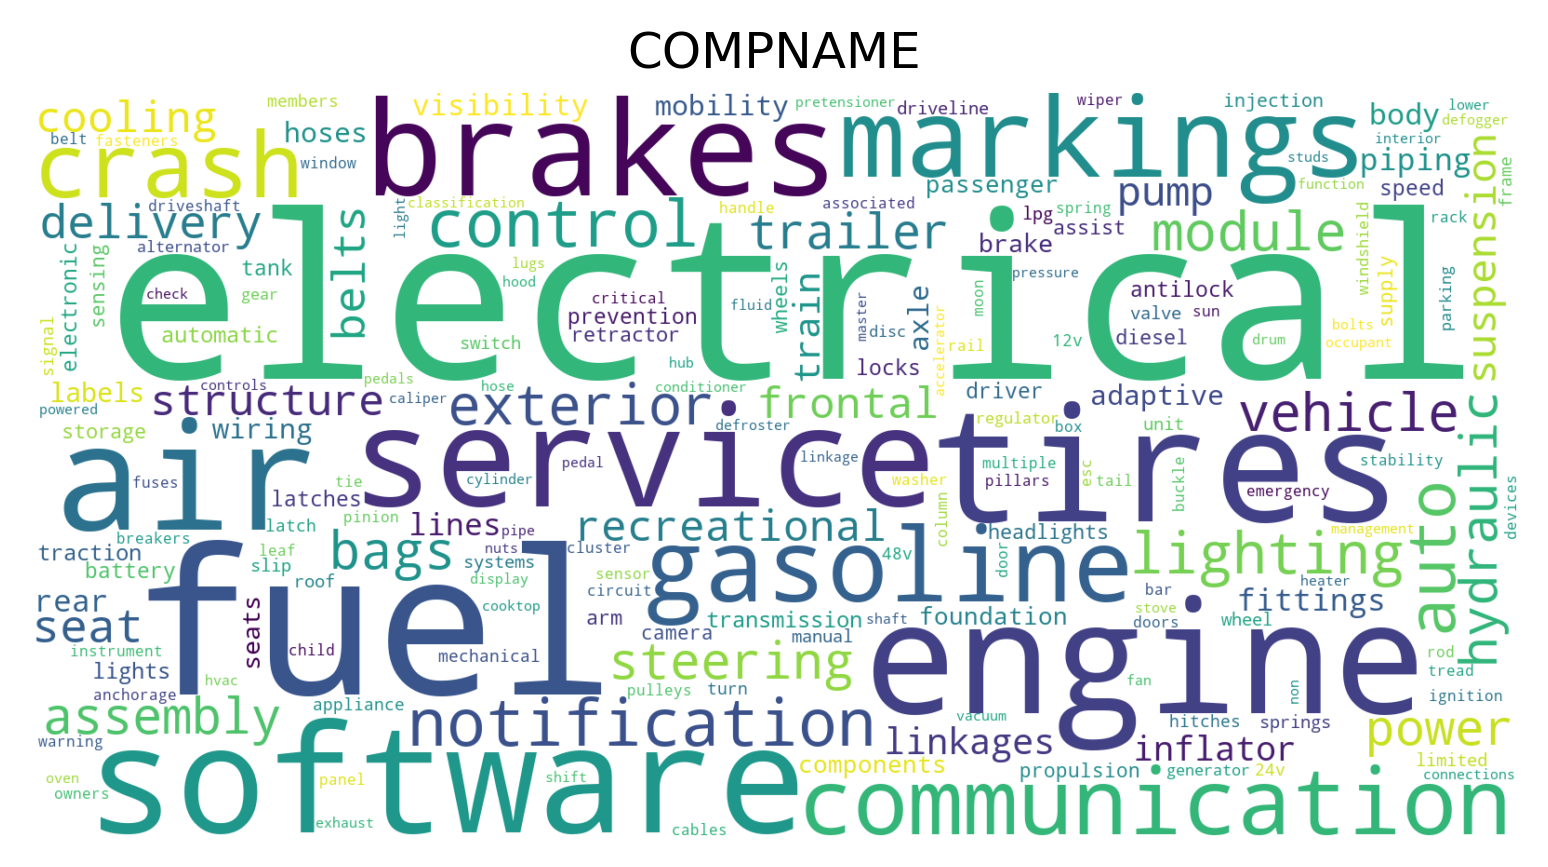

In [42]:
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.title('COMPNAME')

Clear categories of issues visible: Fuel, engine, electrical, software, air, gasoline, seat, brakes.

Note that some issues are directly observable to the human senses, such as fuel and seat problems, but electrical and software issues are most likely identified through other observations, such vehicle stalling, or door opening while child safety lock is on.

Some examples of observable issues linked to deeper root causes that I can think of, with the help of wordmap:
 - Air bag issues can be observed due to faulty electrical and seatbelt sensors.
 - Bad smell can be observed due to break pads overheating.
 - Overheating can be observed due to power train issues.
 - Door open/close issues can be observed due to door latch issue, child safety mode malfunctions.
 - Harsh clutch movements can be observed due to transmission/powertrain issues.
 - Steering wheel issues can be observed due to unbalanced tires.
 - Seat adjustment issues can be observed due to debri in seat latch.
 - Light issues can be observed due to faulty electrical sensors.

In [43]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                regexp="\\b\\w\\w+\\b",
                include_numbers=False,
                collocations=True,
                stopwords=nlp.Defaults.stop_words,
                collocation_threshold=-999,
                relative_scaling=1, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate(df["COMPNAME"].str.cat(sep=" "))

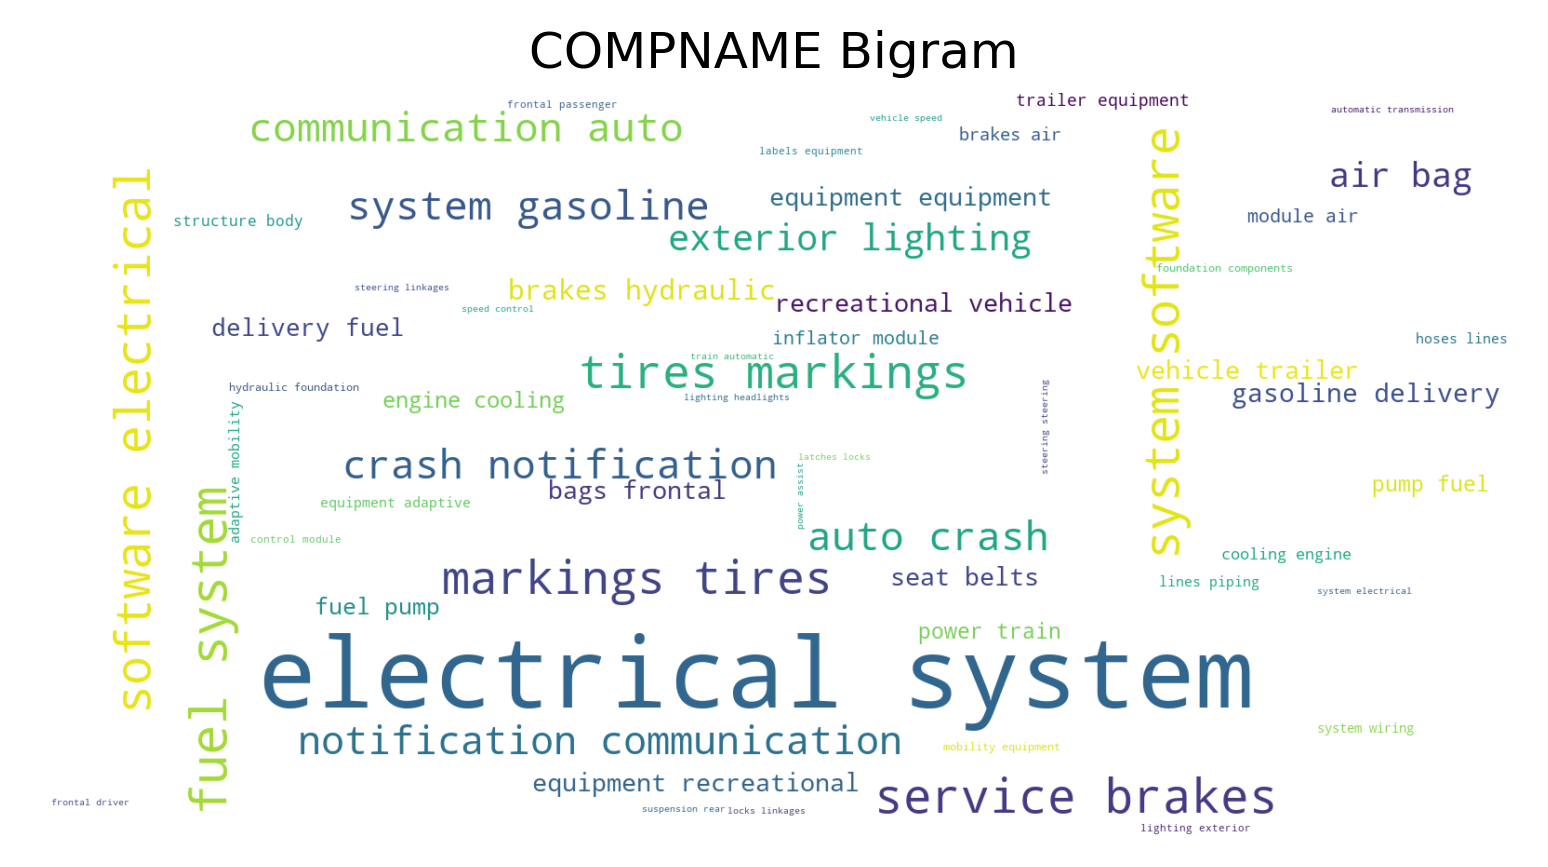

In [44]:
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.title('COMPNAME Bigram')

**I reject my null hypothesis.** I think the exact match is out of the question here, because if a user were to query for recall information, representing it using exact words will not lead to matches for the user.

For example, an exact word matching algorithm will not return recall related to "electrical system issues" from a user query such as "vehicle stalling".

### DESC_DEFECT Wordmap



In [45]:
desc_defect_series = generate_word_frequencies_from_column(df, "DESC_DEFECT")

In [46]:
desc_defect_dict = desc_defect_series.to_dict()["count"]


In [47]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=0.75, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(desc_defect_dict)

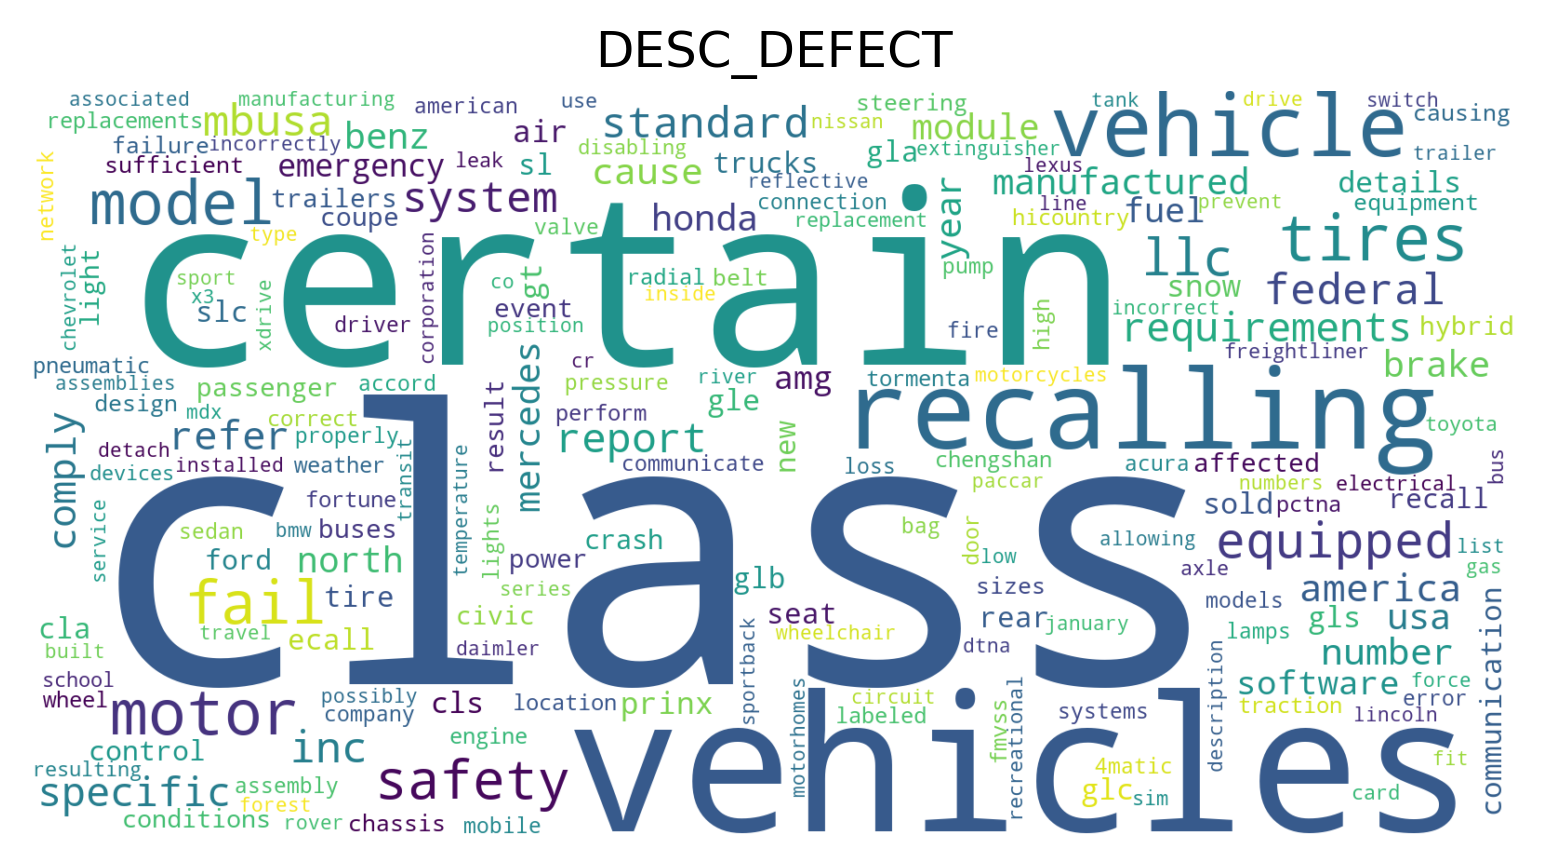

In [48]:
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.title('DESC_DEFECT')

First sentence has a lot of junk information, like this manufacture is recalling specific make, specific class vehicles due to failure and failed some federal requirement. These may still useful pieces of information for retrieval of automotive issues but not relevant to understanding specific recall issues.

As you can see above, even by removing stopwords and numbers (e.g. 2016, 2017) we still get a ton of information about vehicle classes.

### CONSEQUENCE_DEFECT Wordmap



In [49]:
conse_defect_series = generate_word_frequencies_from_column(df, "CONSEQUENCE_DEFECT")

In [50]:
conse_defect_dict = conse_defect_series.to_dict()["count"]


In [51]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=0.75, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(conse_defect_dict)

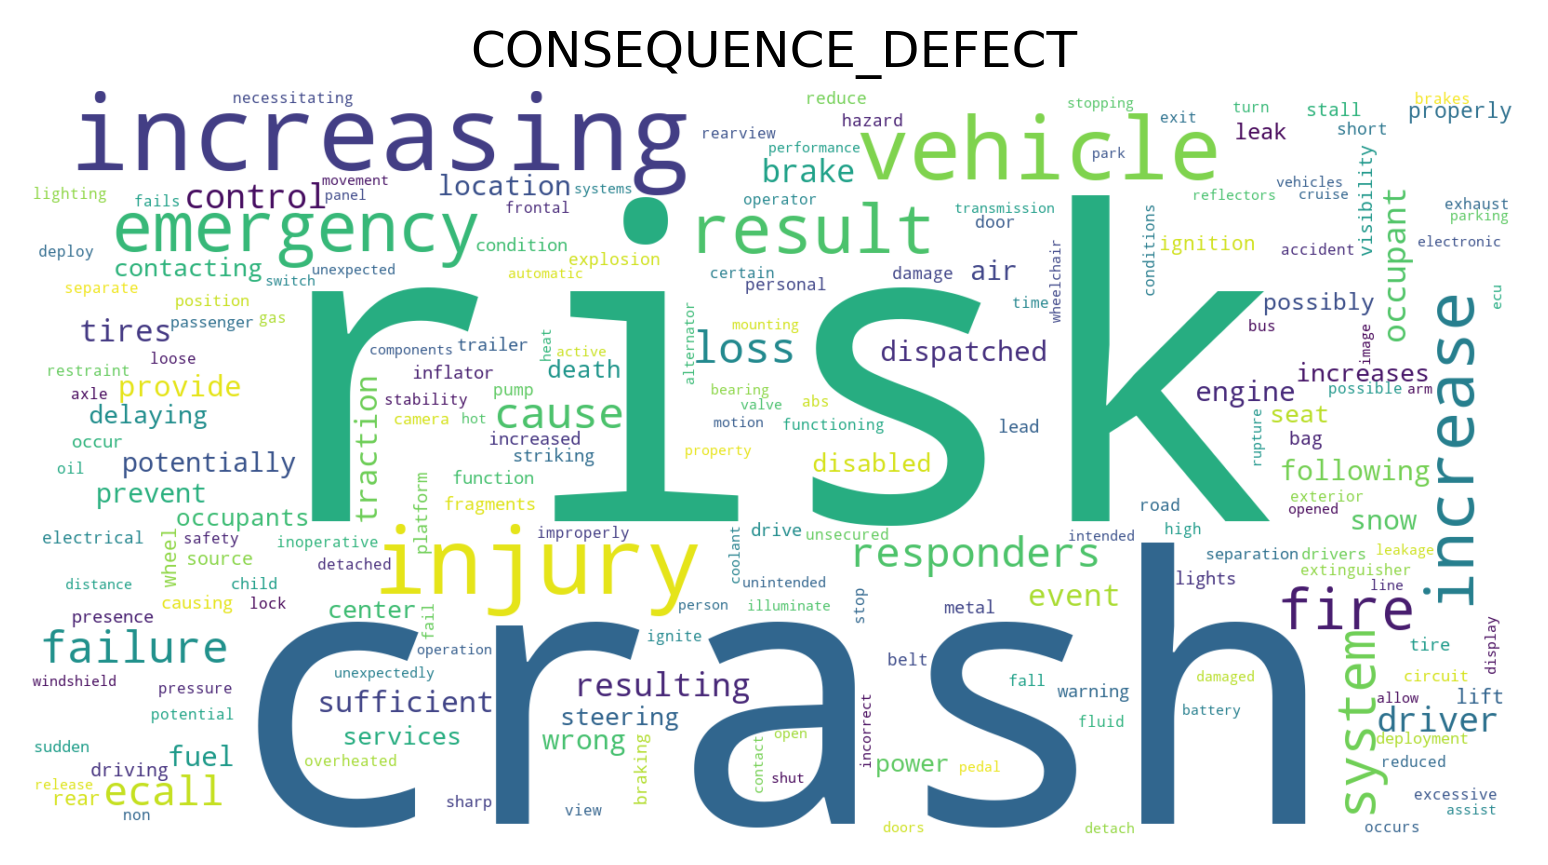

In [52]:
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.title('CONSEQUENCE_DEFECT')

#### General Distribution of Make

In [54]:
df.columns

Index(['RECORD_ID', 'CAMPNO', 'MAKETXT', 'MODELTXT', 'YEARTXT', 'MFGCAMPNO',
       'COMPNAME', 'MFGNAME', 'BGMAN', 'ENDMAN', 'RCLTYPECD', 'POTAFF',
       'ODATE', 'INFLUENCED_BY', 'MFGTXT', 'RCDATE', 'DATEA', 'RPNO', 'FMVSS',
       'DESC_DEFECT', 'CONSEQUENCE_DEFECT', 'CORRECTIVE_ACTION', 'NOTES',
       'RCL_CMPT_ID', 'MFR_COMP_NAME', 'MFR_COMP_DESC', 'MFR_COMP_PTNO'],
      dtype='object')

In [55]:
df["MAKETXT"].unique()

array(['ford', 'jayco', 'holiday rambler', ..., 'american furukawa',
       'nivion', 'iosix'], shape=(3358,), dtype=object)

In [56]:
maketxt_value_counts = df.MAKETXT.value_counts().head(50)

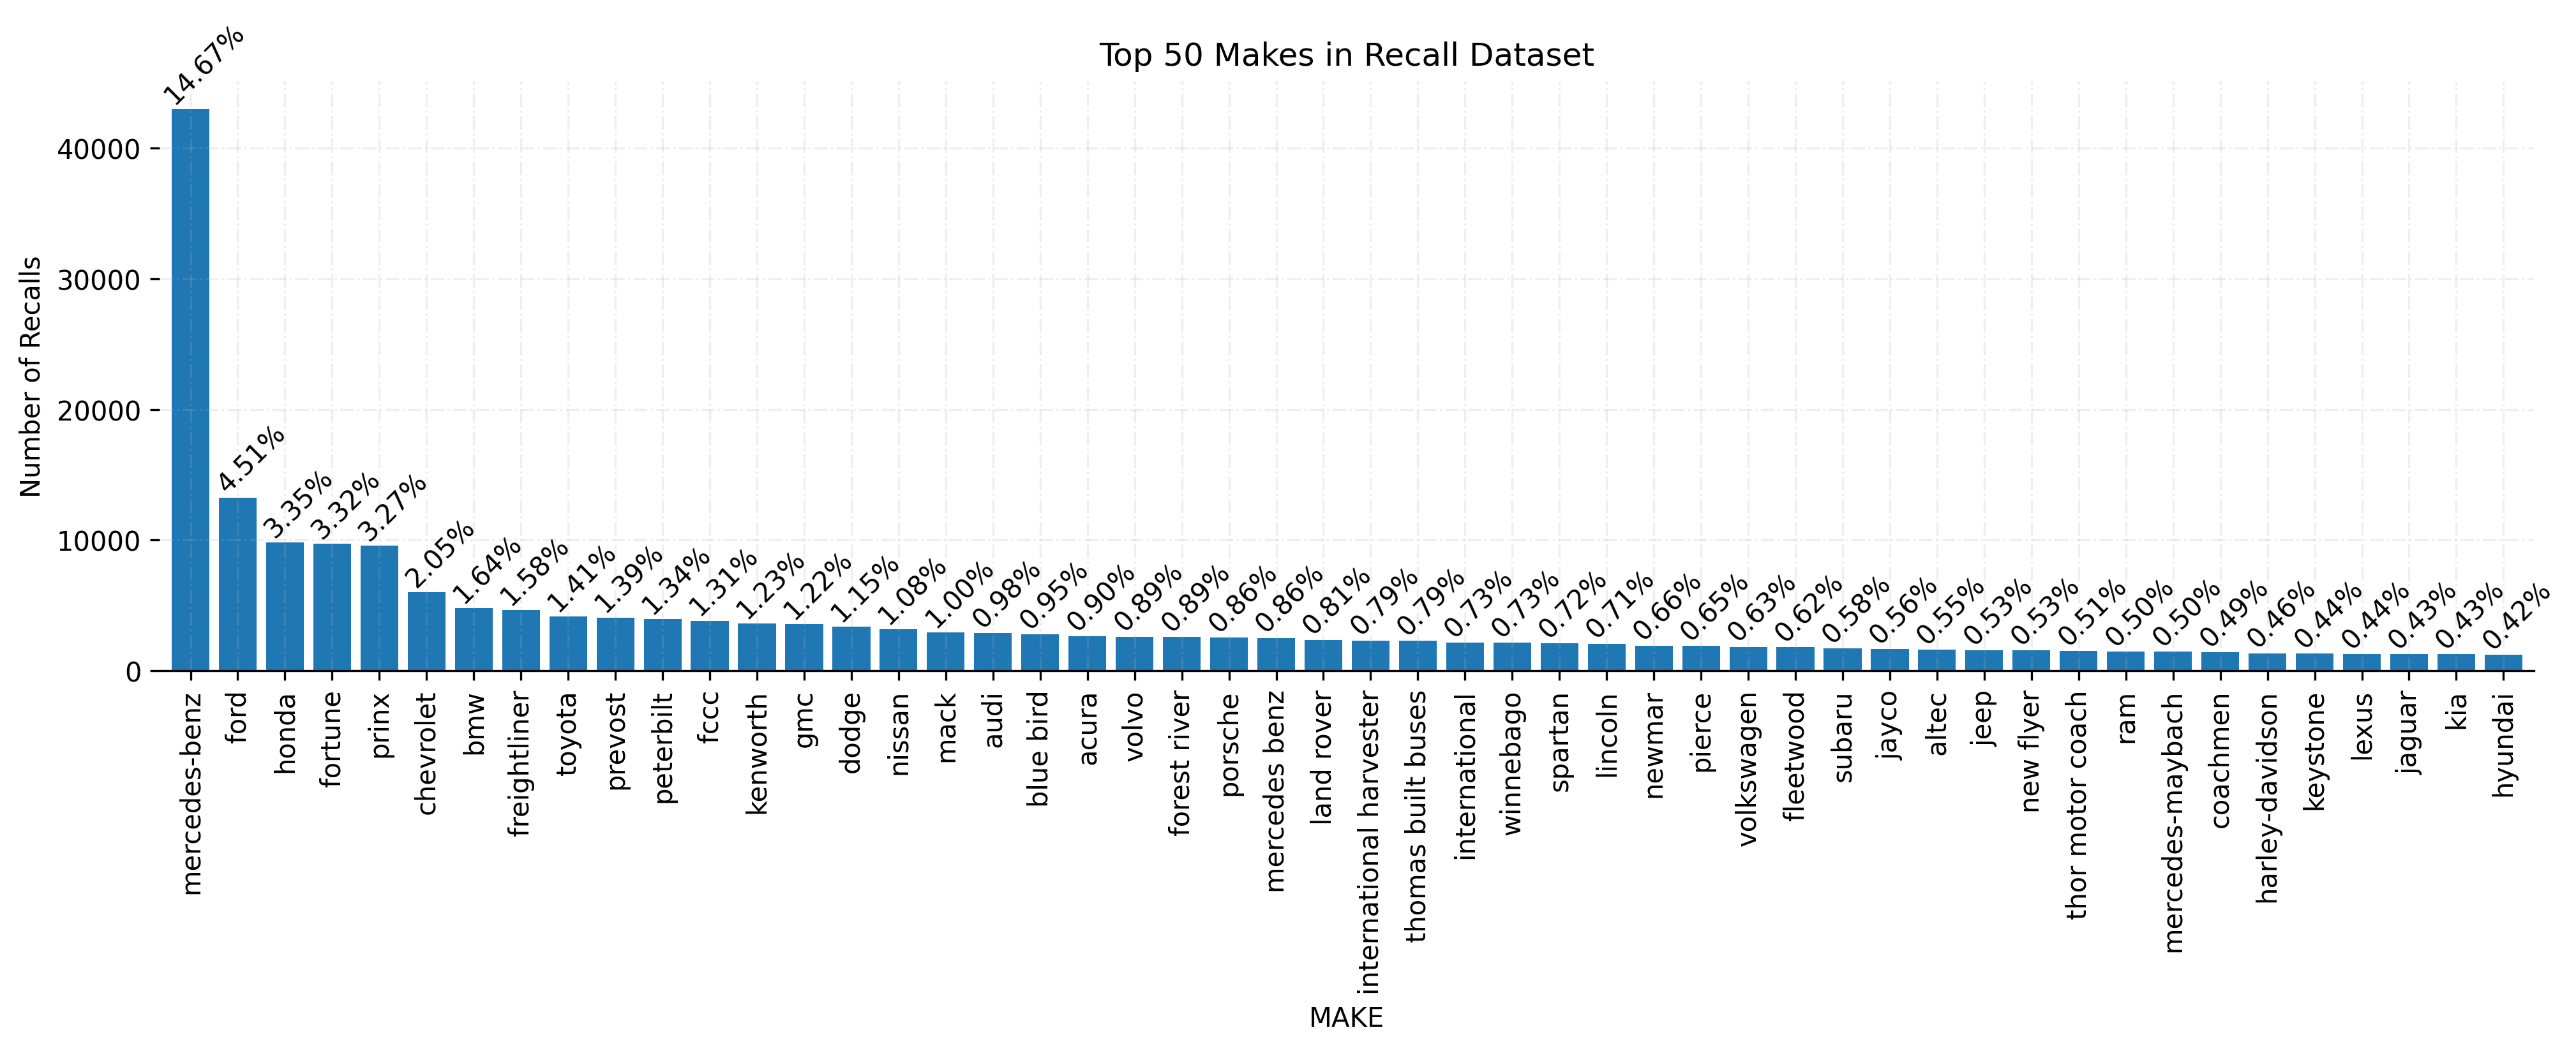

In [57]:
# Plot MAKETXT value counts with percentage text hovering over bar chart
plt.figure(figsize=(16, 4), dpi=300)
maketxt_value_counts = df.MAKETXT.value_counts().head(50)
maketxt_value_counts.plot(kind='bar', width=0.8)
for i, count in enumerate(maketxt_value_counts):
    plt.text(i + 0.3, count, f"{count / len(df) * 100:.2f}%", ha='center', va='bottom', rotation=45)
plt.title('Top 50 Makes in Recall Dataset')
plt.xlabel('MAKE')
plt.ylabel('Number of Recalls')
plt.show()

In [58]:
# No prevalent bigrams according to collocation threshold.

# wordcloud = WordCloud(width = 1600, height = 800,
#                 background_color ='white',
#                 collocations=True,
#                 collocation_threshold=-999,
#                 relative_scaling=0.75, # Ranges from 0-1. 
#                                        # =0.75 weights word size by frequency moreso than word rank
#                 min_font_size = 10).generate_from_frequencies(conse_defect_dict)

In [59]:
ign = (df["CONSEQUENCE_DEFECT"].str.lower().str.contains("ecall").fillna(False))
get_random_row(df.loc[ign])

RECORD_ID: 166344
'COMPNAME: communication: auto crash notification'
('DESC_DEFECT: mercedes-benz usa, llc (mbusa) is recalling certain 2016 - 2021 '
 'cla-class, gla-class, gle-class, gls-class, slc-class, a-class, gt-class, '
 'c-class, e-class, s-class, cls-class, sl-class, b-class, glb-class, '
 'glc-class, and g-class vehicles.  please refer to the part 573 report for '
 'specific vehicle model details.  the software design of the communication '
 'module may fail to communicate the correct vehicle location for the '
 'emergency call system (ecall) in the event of a crash.')
('CONSEQUENCE_DEFECT: failure of the ecall system may result in emergency '
 'responders being dispatched to the wrong location, increasing the risk of '
 'injury following a crash.')
('CORRECTIVE_ACTION: mbusa will notify owners, and the communication module '
 'software will be updated by a dealer, or through an over-the-air (ota) '
 'update, free of charge.  the recall began march 12, 2021.  owners may '
 "

C:\Users\harri\AppData\Local\Temp\ipykernel_77852\3250218938.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ign = (df["CONSEQUENCE_DEFECT"].str.lower().str.contains("ecall").fillna(False))


### CORRECTIVE_ACTION Wordmap



In [64]:
corrective_action_series = generate_word_frequencies_from_column(df, "CORRECTIVE_ACTION")

In [65]:
corrective_actions_dict = corrective_action_series.to_dict()["count"]

In [66]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=0.75, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(corrective_actions_dict)

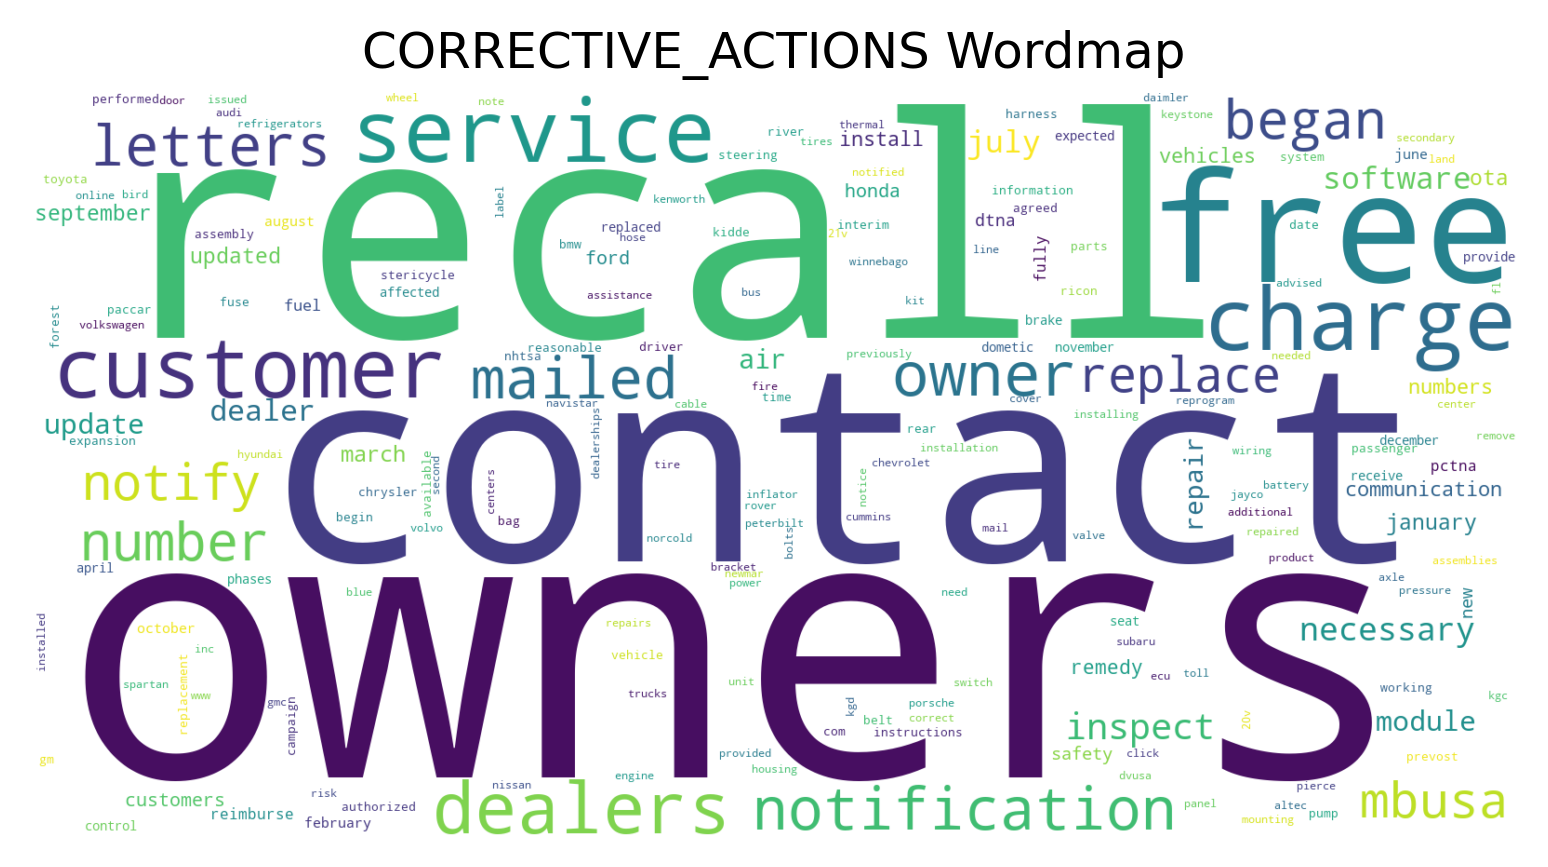

In [67]:
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.title('CORRECTIVE_ACTIONS Wordmap')

### NOTES Wordmap



In [60]:
notes_series = generate_word_frequencies_from_column(df, "NOTES")

In [61]:
notes_dict = notes_series.to_dict()["count"]


In [62]:
wordcloud = WordCloud(width = 1600, height = 800,
                background_color ='white',
                collocations=False,
                relative_scaling=0.75, # Ranges from 0-1. 
                                       # =0.75 weights word size by frequency moreso than word rank
                min_font_size = 10).generate_from_frequencies(notes_dict)

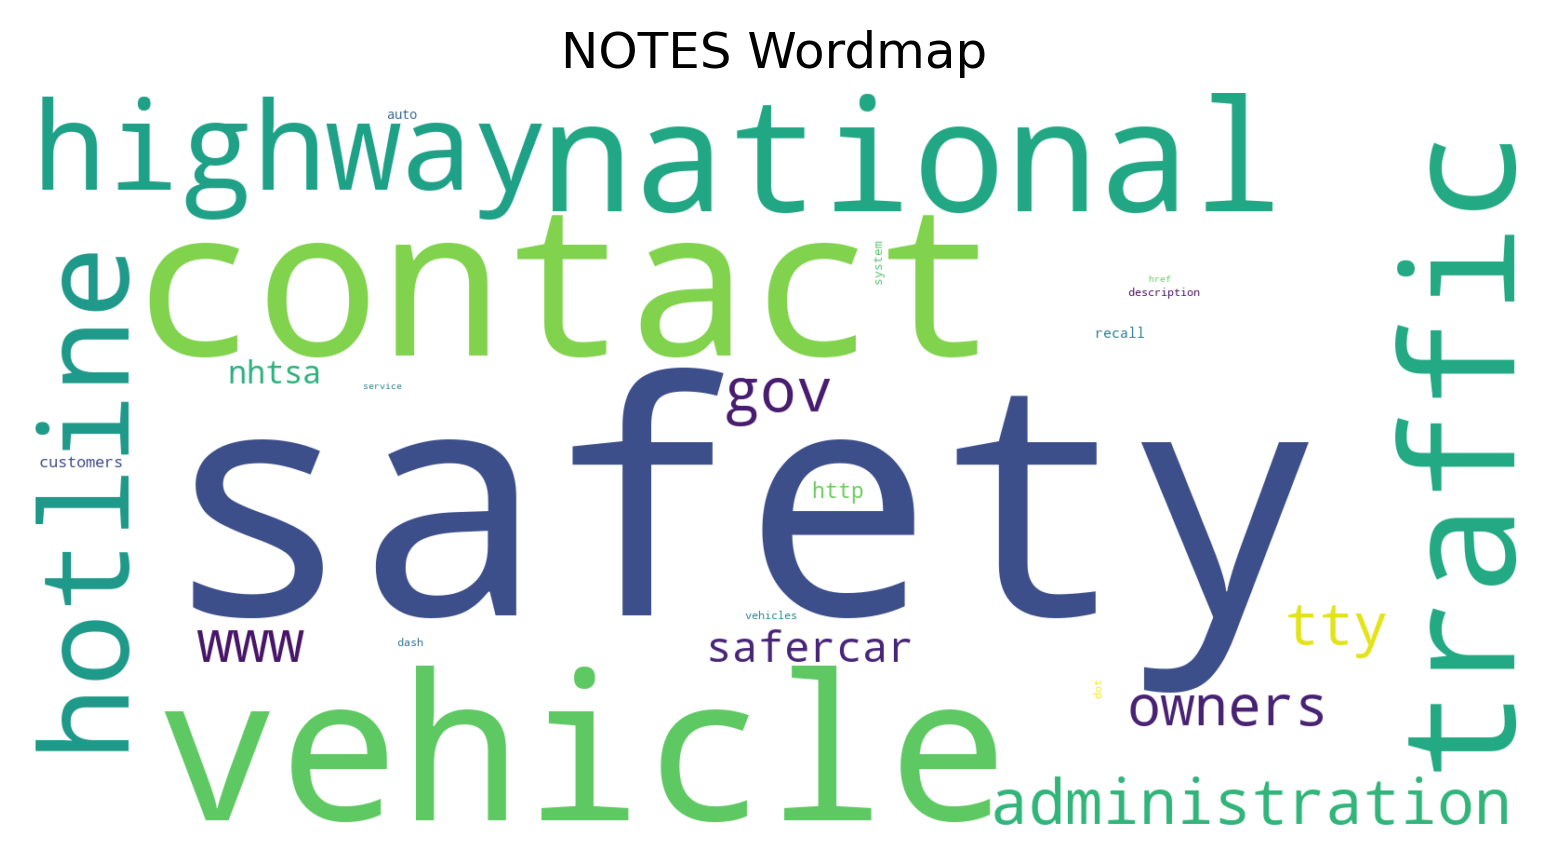

In [63]:
plt.figure(dpi=300)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
_ = plt.title('NOTES Wordmap')

## Data Quality Check

In [13]:
df.columns

Index(['RECORD_ID', 'CAMPNO', 'MAKETXT', 'MODELTXT', 'YEARTXT', 'MFGCAMPNO',
       'COMPNAME', 'MFGNAME', 'BGMAN', 'ENDMAN', 'RCLTYPECD', 'POTAFF',
       'ODATE', 'INFLUENCED_BY', 'MFGTXT', 'RCDATE', 'DATEA', 'RPNO', 'FMVSS',
       'DESC_DEFECT', 'CONSEQUENCE_DEFECT', 'CORRECTIVE_ACTION', 'NOTES',
       'RCL_CMPT_ID', 'MFR_COMP_NAME', 'MFR_COMP_DESC', 'MFR_COMP_PTNO',
       'MMYTXT', 'CDESCR'],
      dtype='object')

In [14]:
len(df)

293171

In [15]:
len(df["RECORD_ID"].unique())

293171

In [16]:
len(df["CAMPNO"].unique())

28780

### Duplicate Check for CAMPNO

Assume all records should be unique on CAMPNO

In [112]:
# Exclude RECORD_ID
find_columns_defining_uniqueness(df.drop("RECORD_ID", axis=1))

RCL_CMPT_ID           185714
MMYTXT                169861
MODELTXT               73055
YEARTXT                67301
MAKETXT                34859
MFR_COMP_PTNO          33104
COMPNAME               31142
MFR_COMP_DESC          30390
MFGTXT                 30247
MFR_COMP_NAME          29760
DATEA                  28780
DESC_DEFECT            28780
RPNO                   28780
RCLTYPECD              28780
MFGNAME                28780
MFGCAMPNO              28780
RCDATE                 28780
INFLUENCED_BY          28780
CONSEQUENCE_DEFECT     28780
NOTES                  28780
CORRECTIVE_ACTION      28780
FMVSS                  28780
POTAFF                 28737
ODATE                  26507
BGMAN                  26123
ENDMAN                 25719
dtype: int64
RCL_CMPT_ID           12808
MMYTXT                 9725
MFR_COMP_PTNO          5640
MODELTXT               4027
YEARTXT                3623
MFR_COMP_DESC          2926
MFR_COMP_NAME          2296
COMPNAME               1660
MAKETXT  

['CAMPNO',
 'RCL_CMPT_ID',
 'MMYTXT',
 'MFR_COMP_PTNO',
 'YEARTXT',
 'MODELTXT',
 'MFR_COMP_DESC',
 'MFR_COMP_NAME',
 'COMPNAME',
 'MAKETXT']

In [ ]:
df.loc[df.duplicated(
    subset=['CAMPNO',
            'RCL_CMPT_ID',
            'MMYTXT',
            'MFR_COMP_PTNO',
    ], keep=False)
]

RECORD_ID     CAMPNO                  MAKETXT         MODELTXT  \
1189         1190  06t004000                   cooper  cooper zeon 2xs   
1190         1191  06t004000                   cooper  cooper zeon 2xs   
1476         1477  02v137000  international harvester             4000   
1477         1478  02v137000  international harvester             4000   
1478         1479  02v137000  international harvester             4000   
...           ...        ...                      ...              ...   
292700     292704  25v031000                    acura       tlx type s   
292701     292705  25v031000                    acura       tlx type s   
292702     292706  25v031000                    acura       tlx type s   
293025     293029  25v012000                chevrolet       equinox ev   
293026     293030  25v012000                chevrolet       equinox ev   

        YEARTXT   MFGCAMPNO  \
1189       9999         146   
1190       9999         146   
1476       1998       01505   
1477       1998       01505   
1478       1999       01505   
...         ...         ...   
292700     2021    el1, al0   
292701     2021    el1, al0   
292702     2021    el1, al0   
293025     2025  n242481530   
293026     2025  n242481530   

                                                 COMPNAME  \
1189                                                tires   
1190                                                tires   
1476                                                tires   
1477                                               wheels   
1478                                                tires   
...                                                   ...   
292700                         electrical system:software   
292701                         electrical system:software   
292702                         electrical system:software   
293025                          service brakes, hydraulic   
293026  forward collision avoidance: adaptive cruise c...   

                                 MFGNAME       BGMAN      ENDMAN  ... FMVSS  \
1189            cooper tire & rubber co.         NaN         NaN  ...         
1190            cooper tire & rubber co.         NaN         NaN  ...         
1476      international truck and engine  19860101.0  20010116.0  ...         
1477      international truck and engine  19860101.0  20010116.0  ...         
1478      international truck and engine  19860101.0  20010116.0  ...         
...                                  ...         ...         ...  ...   ...   
292700  honda (american honda motor co.)         NaN         NaN  ...         
292701  honda (american honda motor co.)         NaN         NaN  ...         
292702  honda (american honda motor co.)         NaN         NaN  ...         
293025               general motors, llc         NaN         NaN  ...         
293026               general motors, llc         NaN         NaN  ...         

                                              DESC_DEFECT  \
1189    certain cooper zeon 2xs, sizes 235/35r19xl and...   
1190    certain cooper zeon 2xs, sizes 235/35r19xl and...   
1476    certain heavy duty trucks, truck tractors, and...   
1477    certain heavy duty trucks, truck tractors, and...   
1478    certain heavy duty trucks, truck tractors, and...   
...                                                   ...   
292700  honda (american honda motor co.) is recalling ...   
292701  honda (american honda motor co.) is recalling ...   
292702  honda (american honda motor co.) is recalling ...   
293025  general motors, llc (gm) is recalling certain ...   
293026  general motors, llc (gm) is recalling certain ...   

                                       CONSEQUENCE_DEFECT  \
1189    driving on under-inflated tires may result in ...   
1190    driving on under-inflated tires may result in ...   
1476    tires mounted on rims that are too narrow coul...   
1477    tires mounted on rims that are too narrow coul...   
1478    tires mounted on r

In [ ]:
## Dataframes duplicated on CAMPNO, RCL_CMPT_ID, MMYTXT, MFR_COMP_PTNO 
## but not duplicated when MFR_COMP_DESC is present
df.loc[
    df.duplicated(
        subset=['CAMPNO',
                'RCL_CMPT_ID',
                'MMYTXT',
                'MFR_COMP_PTNO',
        ], keep=False
    ) & (
      ~df.duplicated(
        subset=['CAMPNO',
                'RCL_CMPT_ID',
                'MMYTXT',
                'MFR_COMP_PTNO',
                'MFR_COMP_DESC',
        ], keep=False
      )   
    ), [
        'CAMPNO',
        'RCL_CMPT_ID',
        'MMYTXT',
        'MFR_COMP_PTNO',
        'MFR_COMP_DESC',
        "DESC_DEFECT"
        ]
].head(20)

CAMPNO                  RCL_CMPT_ID  \
149011  20v631000  000106166004322717000000073   
149017  20v631000  000106166004322717000000073   
149020  20v631000  000106166004322718000000073   
149026  20v631000  000106166004322718000000073   
149029  20v631000  000106166004322719000000073   
149035  20v631000  000106166004322719000000073   
149038  20v631000  000106166004322720000000073   
149044  20v631000  000106166004322720000000073   
156575  20e048000  000104304004446731000000316   
156576  20e048000  000104304004446731000000316   
156621  20v743000  000107327004421736000000073   
156625  20v743000  000107327004421736000000073   
157695  20v770000  000107493000217983000000192   
157701  20v770000  000107493000217983000000192   
157702  20v770000  000107493000217983000000192   
157708  20v770000  000107493000217983000000192   
157709  20v770000  000107493000322628000000192   
157715  20v770000  000107493000322628000000192   
157716  20v770000  000107493000322628000000192   
157722  20v770000  000107493000322628000000192   

                                           MMYTXT  MFR_COMP_PTNO  \
149011           mercedes-benz sprinter 1500 2020    a9074284200   
149017           mercedes-benz sprinter 1500 2020    a9074284200   
149020           mercedes-benz sprinter 2500 2020    a9074284200   
149026           mercedes-benz sprinter 2500 2020    a9074284200   
149029           mercedes-benz sprinter 3500 2020    a9074284200   
149035           mercedes-benz sprinter 3500 2020    a9074284200   
149038           mercedes-benz sprinter 4500 2020    a9074284200   
149044           mercedes-benz sprinter 4500 2020    a9074284200   
156575  curt manufacturing rambler rv towbar 9999                  
156576  curt manufacturing rambler rv towbar 9999                  
156621                     coachmen galleria 2021    a9074284200   
156625                     coachmen galleria 2021    a9074284200   
157695                             honda fit 2007  44306-tr2-305   
157701                             honda fit 2007  44306-tr2-305   
157702                             honda fit 2007  44305-tr2-305   
157708                             honda fit 2007  44305-tr2-305   
157709                             honda fit 2008  44306-tr2-305   
157715                             honda fit 2008  44306-tr2-305   
157716                             honda fit 2008  44305-tr2-305   
157722                             honda fit 2008  44305-tr2-305   

                    MFR_COMP_DESC  \
149011  brake hose front axle 4x2   
149017   brake hose rear axle 4x2   
149020  brake hose front axle 4x2   
149026   brake hose rear axle 4x2   
149029  brake hose front axle 4x2   
149035   brake hose rear axle 4x2   
149038  brake hose front axle 4x2   
149044   brake hose rear axle 4x2   
156575            axial pivot pin   
156576         guide rod fastener   
156621  brake hose front axle 4x2   
156625   brake hose rear axle 4x2   
157695               civic hybrid   
157701                 ilx hybrid   
157702               civic hybrid   
157708                 ilx hybrid   
157709               civic hybrid   
157715                 ilx hybrid   
157716               civic hybrid   
157722                 ilx hybrid   

                                              DESC_DEFECT  
149011  daimler vans usa, llc (dvusa) is recalling cer...  
149017  daimler vans usa, llc (dvusa) is recalling cer...  
149020  daimler vans usa, llc (dvusa) is recalling cer...  
149026  daimler vans usa, llc (dvusa) is recalling cer...  
149029  daimler vans usa, llc (dvusa) is recalling cer...  
149035  daimler vans usa, llc (dvusa) is recalling cer...  
149038  daimler vans usa, llc (dvusa) is recalling cer...  
149044  daimler vans usa, llc (dvusa) is recalling cer...  
156575  curt manufacturing llc. (curt manufacturing) i...  
156576  curt manufacturing llc. (curt manufacturing) i...  
156621  forest river, inc. (forest river) is recalling...  
156625  forest river, inc. (fores

In [ ]:
## Dataframes duplicated on CAMPNO, RCL_CMPT_ID, MMYTXT 
## but not duplicated when MFR_COMP_PTNO is present
df.loc[
    df.duplicated(
        subset=['CAMPNO',
                'RCL_CMPT_ID',
                'MMYTXT',
        ], keep=False
    ) & (
      ~df.duplicated(
        subset=['CAMPNO',
                'RCL_CMPT_ID',
                'MMYTXT',
                'MFR_COMP_PTNO',
        ], keep=False
      )   
    ), [
        'CAMPNO',
        'RCL_CMPT_ID',
        'MMYTXT',
        'MFR_COMP_PTNO',
        'MFR_COMP_DESC',
        "DESC_DEFECT"
        ]
].head(20)

CAMPNO                  RCL_CMPT_ID  \
61911   24v700000  000127470004229310000001305   
61912   24v700000  000127470004229310000001305   
61913   24v700000  000127470004229310000001305   
61914   24v700000  000127470004229310000001794   
61915   24v700000  000127470004229310000001794   
61916   24v700000  000127470004229310000001794   
61917   24v700000  000127470004265726000001305   
61918   24v700000  000127470004265726000001305   
61919   24v700000  000127470004265726000001305   
61920   24v700000  000127470004265726000001794   
61921   24v700000  000127470004265726000001794   
61922   24v700000  000127470004265726000001794   
137326  19v212000  000097446004027719000000227   
137327  19v212000  000097446004027719000000227   
137328  19v212000  000097446004027719000000227   
137329  19v212000  000097446004027719000000227   
142197  20e025000  000102684004227427000000217   
142198  20e025000  000102684004227427000000217   
142199  20e025000  000102684004226907000000217   
142200  20e025000  000102684004226907000000217   

                                           MMYTXT MFR_COMP_PTNO  \
61911                            nissan leaf 2019   295b0 5sa0c   
61912                            nissan leaf 2019   295b0 5sa1c   
61913                            nissan leaf 2019   295b0 5sf0a   
61914                            nissan leaf 2019   295b0 5sa0c   
61915                            nissan leaf 2019   295b0 5sa1c   
61916                            nissan leaf 2019   295b0 5sf0a   
61917                            nissan leaf 2020   295b0 5sa0c   
61918                            nissan leaf 2020   295b0 5sa1c   
61919                            nissan leaf 2020   295b0 5sf0a   
61920                            nissan leaf 2020   295b0 5sa0c   
61921                            nissan leaf 2020   295b0 5sa1c   
61922                            nissan leaf 2020   295b0 5sf0a   
137326  alexis fire equipment fire apparatus 2018         60btt   
137327  alexis fire equipment fire apparatus 2018        60bttd   
137328  alexis fire equipment fire apparatus 2018         70btt   
137329  alexis fire equipment fire apparatus 2018         m6btt   
142197                           lincoln mkz 2015  dp5z-13008-t   
142198                           lincoln mkz 2015   dp5z-3008-v   
142199                           lincoln mkz 2013  dp5z-13008-t   
142200                           lincoln mkz 2013   dp5z-3008-v   

                                    MFR_COMP_DESC  \
61911                             battery ? 40kwh   
61912                             battery ? 60kwh   
61913                             battery ? 60kwh   
61914                             battery ? 40kwh   
61915                             battery ? 60kwh   
61916                             battery ? 60kwh   
61917                             battery ? 40kwh   
61918                             battery ? 60kwh   
61919                             battery ? 60kwh   
61920                             battery ? 40kwh   
61921                             battery ? 60kwh   
61922                             battery ? 60kwh   
137326          600 led brake tail turn light red   
137327  600 led brake tail turn light red deutsch   
137328          700 led brake tail turn light red   
137329       m6 led brake tail turn light red 12v   
142197                                   headlamp   
142198                                   headlamp   
142199                                   headlamp   
142200                                   headlamp   

                                              DESC_DEFECT  
61911   nissan north america, inc. (nissan) is recalli...  
61912   nissan north america, inc. (nissan) is recalli...  
61913   nissan north america, inc. (nissan) is recalli...  
61914   nissan north america, inc. (nissan) is recalli...  
61915   nissan north america, inc. (nissan) is recalli...  
61916   nissan north america, inc. (nissan) is recalli...  
61917   nissan nor

### Duplicate Check for CDESCR

In [18]:
# Exclude RECORD_ID
find_columns_defining_uniqueness(
    df.drop("RECORD_ID", axis=1),
    uniqueness_column="CDESCR"
)

RCL_CMPT_ID           185714
MMYTXT                167401
MODELTXT               69799
YEARTXT                63089
MAKETXT                32553
MFR_COMP_PTNO          30500
CAMPNO                 28780
COMPNAME               28763
NOTES                  28703
MFGTXT                 28193
MFR_COMP_DESC          27786
POTAFF                 27779
RCDATE                 27578
MFR_COMP_NAME          27156
MFGNAME                26818
DATEA                  26302
MFGCAMPNO              26211
INFLUENCED_BY          26197
RCLTYPECD              26179
CONSEQUENCE_DEFECT     26176
DESC_DEFECT            26176
RPNO                   26176
FMVSS                  26176
CORRECTIVE_ACTION      26176
ODATE                  25861
BGMAN                  25544
ENDMAN                 25121
dtype: int64
RCL_CMPT_ID           12808
MMYTXT                 9725
MFR_COMP_PTNO          5640
MODELTXT               4027
YEARTXT                3623
MFR_COMP_DESC          2926
MFR_COMP_NAME          2296
COMPNAME

['CDESCR',
 'RCL_CMPT_ID',
 'MMYTXT',
 'MFR_COMP_PTNO',
 'YEARTXT',
 'MODELTXT',
 'MFR_COMP_DESC',
 'MFR_COMP_NAME',
 'COMPNAME',
 'MAKETXT']

### Check Superseded Campaigns

In [143]:
df_superseded = df.loc[
    df["CORRECTIVE_ACTION"].str.contains("superseded"),
    ['CAMPNO', 'RCL_CMPT_ID', 'MMYTXT', 'MFR_COMP_PTNO', 'MFR_COMP_DESC', "CORRECTIVE_ACTION"]
]

In [144]:
camp_no_rand = df_superseded.sample(
    random_state=42
)["CAMPNO"].iloc[0]

In [ ]:
df_superseded.loc[
    df["CAMPNO"] == camp_no_rand
]["CORRECTIVE_ACTION"]

'freightliner will notify owners and replace the defective valves free of charge.  the recall began on june 28, 2006 to freightliner, sterling, and fccc owners.  thomas built mailed letters to owners beginning july 27, 2006.   this recall has been superseded (replaced) by recall 07v302 (fl-504).'

idk what the recall number 07v302 means. I can't find it in our dataset

In [159]:
df.loc[
    df["CAMPNO"] == "07v302"
]

Empty DataFrame
Columns: [RECORD_ID, CAMPNO, MAKETXT, MODELTXT, YEARTXT, MFGCAMPNO, COMPNAME, MFGNAME, BGMAN, ENDMAN, RCLTYPECD, POTAFF, ODATE, INFLUENCED_BY, MFGTXT, RCDATE, DATEA, RPNO, FMVSS, DESC_DEFECT, CONSEQUENCE_DEFECT, CORRECTIVE_ACTION, NOTES, RCL_CMPT_ID, MFR_COMP_NAME, MFR_COMP_DESC, MFR_COMP_PTNO, MMYTXT]
Index: []

[0 rows x 28 columns]

In [160]:
df.loc[
    df["MFGCAMPNO"] == "07v302"
]

Empty DataFrame
Columns: [RECORD_ID, CAMPNO, MAKETXT, MODELTXT, YEARTXT, MFGCAMPNO, COMPNAME, MFGNAME, BGMAN, ENDMAN, RCLTYPECD, POTAFF, ODATE, INFLUENCED_BY, MFGTXT, RCDATE, DATEA, RPNO, FMVSS, DESC_DEFECT, CONSEQUENCE_DEFECT, CORRECTIVE_ACTION, NOTES, RCL_CMPT_ID, MFR_COMP_NAME, MFR_COMP_DESC, MFR_COMP_PTNO, MMYTXT]
Index: []

[0 rows x 28 columns]

In [141]:
df.loc[
    df["CAMPNO"] == camp_no_rand
]

RECORD_ID     CAMPNO             MAKETXT           MODELTXT  YEARTXT  \
38845      38846  06v205000        freightliner           coronado     2007   
38846      38847  06v205000        freightliner  business class m2     2007   
38847      38848  06v205000        freightliner            classic     2007   
38848      38849  06v205000                fccc                 b2     2007   
38849      38850  06v205000        freightliner                 s2     2007   
38850      38851  06v205000  thomas built buses                hdx     2007   
38851      38852  06v205000  thomas built buses                 c2     2007   
38852      38853  06v205000        freightliner             argosy     2007   
38853      38854  06v205000        freightliner              cargo     2007   
38854      38855  06v205000        freightliner  century class s/t     2007   
38855      38856  06v205000        freightliner                fld     2007   
38856      38857  06v205000        freightliner           columbia     2007   
38857      38858  06v205000            sterling              cargo     2007   
38858      38859  06v205000            sterling                 at     2007   
38859      38860  06v205000            sterling                  l     2007   
38860      38861  06v205000            sterling                 lt     2007   
38861      38862  06v205000            sterling            acterra     2007   

      MFGCAMPNO                        COMPNAME           MFGNAME       BGMAN  \
38845    fl-477  parking brake:conventional:air  freightliner llc  20060401.0   
38846    fl-477  parking brake:conventional:air  freightliner llc  20060401.0   
38847    fl-477  parking brake:conventional:air  freightliner llc  20060401.0   
38848    fl-477  parking brake:conventional:air  freightliner llc  20060401.0   
38849    fl-477  parking brake:conventional:air  freightliner llc  20060401.0   
38850    fl-477  parking brake:conventional:air  freightliner llc  20060401.0   
38851    fl-477  parking brake:conventional:air  freightliner llc  20060401.0   
38852    fl-477  parking brake:conventional:air  freightliner llc  20060401.0   
38853    fl-477  parking brake:conventional:air  freightliner llc  20060401.0   
38854    fl-477  parking brake:conventional:air  freightliner llc  20060401.0   
38855    fl-477  parking brake:conventional:air  freightliner llc  20060401.0   
38856    fl-477  parking brake:conventional:air  freightliner llc  20060401.0   
38857    fl-477  parking brake:conventional:air  freightliner llc  20060401.0   
38858    fl-477  parking brake:conventional:air  freightliner llc  20060401.0   
38859    fl-477  parking brake:conventional:air  freightliner llc  20060401.0   
38860    fl-477  parking brake:conventional:air  freightliner llc  20060401.0   
38861    fl-477  parking brake:conventional:air  freightliner llc  20060401.0   

           ENDMAN  ... FMVSS  \
38845  20060526.0  ...         
38846  20060526.0  ...         
38847  20060526.0  ...         
38848  20060526.0  ...         
38849  20060526.0  ...         
38850  20060526.0  ...         
38851  20060526.0  ...         
38852  20060526.0  ...         
38853  20060526.0  ...         
38854  20060526.0  ...         
38855  20060526.0  ...         
38856  20060526.0  ...         
38857  20060526.0  ...         
38858  20060526.0  ...         
38859  20060526.0  ...         
38860  20060526.0  ...         
38861  20060526.0  ...         

                                             DESC_DEFECT  \
38845  certain heavy trucks, shuttle buses, and  scho...   
38846  certain heavy trucks, shuttle buses, and  scho...   
38847  certain heavy trucks, shuttle buses, and  scho...   
38848  certain heavy trucks, shuttle buses, and  scho...   
38849  certain heavy trucks, shuttle buses, and  scho...   
38850  certain heavy trucks, shuttle buses, and  scho...   
38851  certain heavy trucks, shuttle buses, and  scho...   
38852  certain heavy trucks, shuttle buses, and  scho...   
38853  c

In [134]:
df["MFGCAMPNO"].unique()

array(['02s41', '', '902b/02kw4', ..., 'cr5691', 'b7b', 'pjw'],
      shape=(11419,), dtype=object)